# U_net recreation 

## Purpose: Recreate U_net architecture according to the original paper. Adjust the architecture to run on a laptop with a single NVIDIA RTX 3060 (laptop). Train the adjusted the model on "TGS Salt Identification Challenge" and make inferences. Upload the best model to Github 

## Introduction: U_net is a popular image segmentation model. Recently, the model is used for denoising in deffusion models. The model consist of various contracting layers and expanding layers making up a U shape. The number of feature channels of an image is doubled for each contracting layer and halved for each expanding layer. A classifier layer return the number of feature layer according to the number of classification needed.

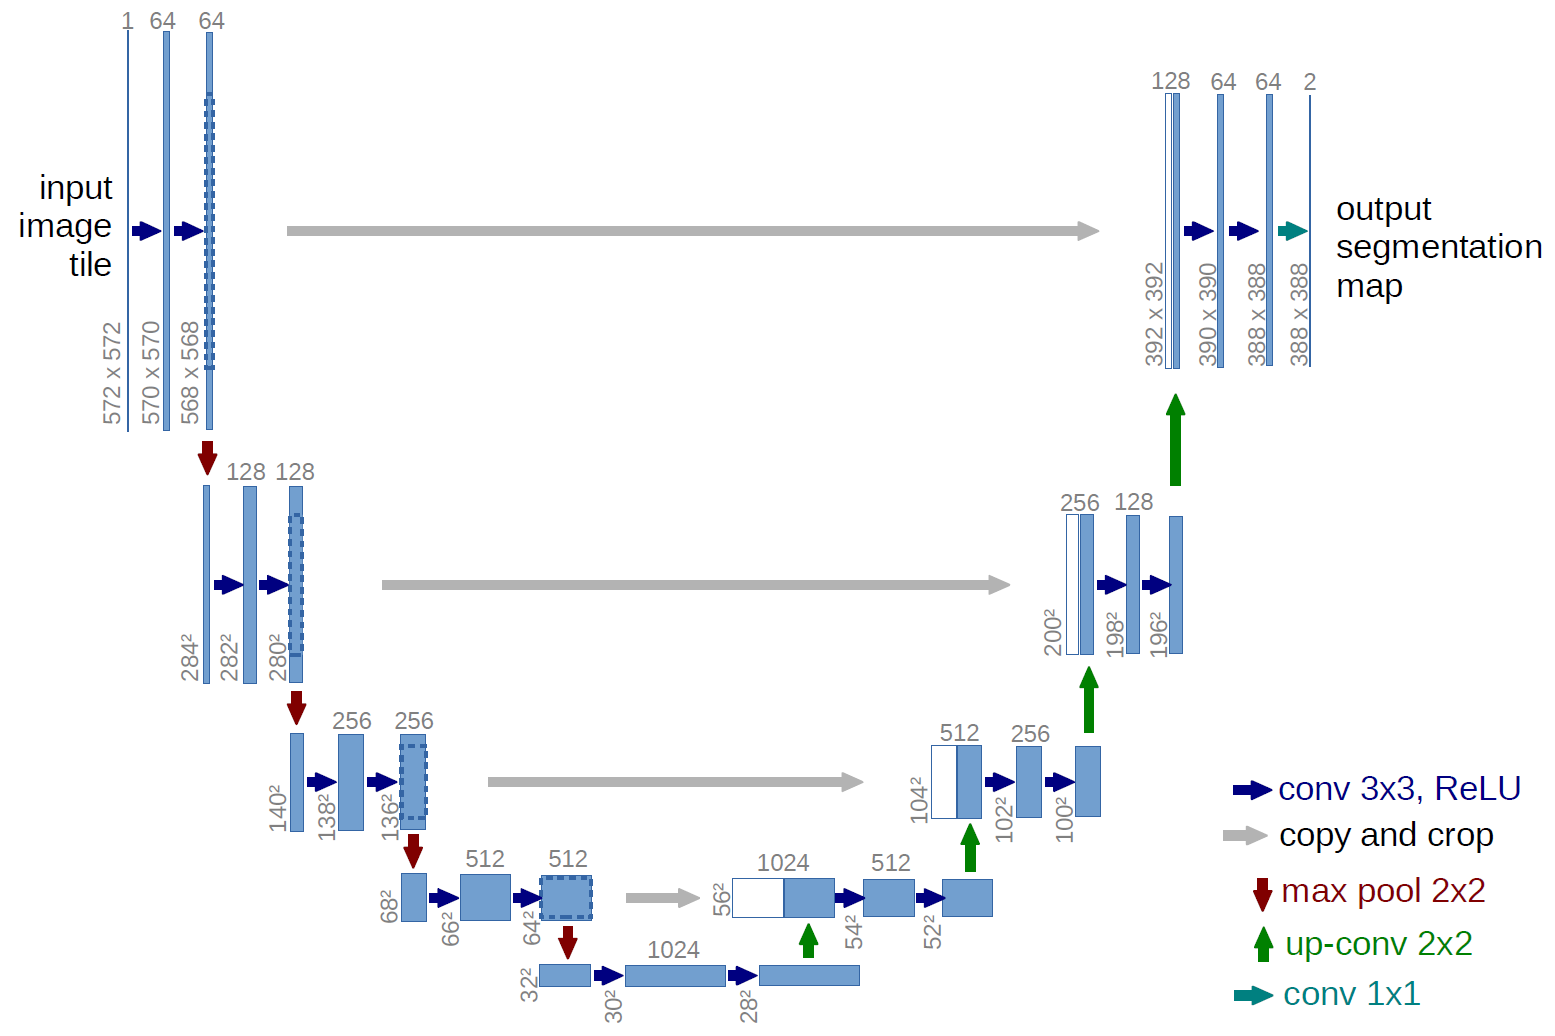

## Method:

#### 1. Import dependencies and set up device diagnostic

In [27]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchinfo import summary
from pathlib import Path
import os
import random
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import glob
import shutil
from typing import Tuple, Dict, List
from torch.utils.data import DataLoader

import torch.nn.functional as F
import lightning as L

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### 2. Create the data set. The "TGS Salt Identification Challenge" data set is from downloaded from Kaggle. The folder is organized into 2 folders: "train" and "validation". The "train" folder has 2 folders: "images" and "masks" containing RGB 101x101 images and their corresponding masked image. The "validation" folder contain only an "images" folder.

##### I want to split the images and their respective masks into a "train" and a "validation" group since the existing "validation"folder contain no mask images to evaluate our model. 

In [29]:
# Set up path to data directory
data_directory_path = Path("C:/Users/nemol/U_net_recreation/data")
data_directory_path

WindowsPath('C:/Users/nemol/U_net_recreation/data')

Random image path: C:\Users\nemol\U_net_recreation\data\test\images\05454fe6a8.png
Image height: 101
Image width: 101


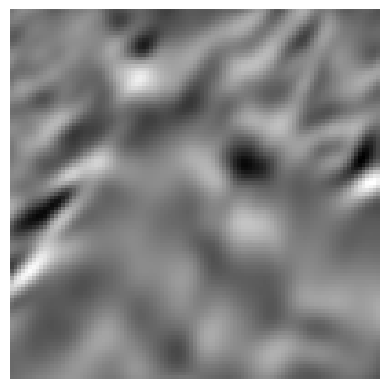

In [31]:
# 1.Get all image paths
image_path_list = list(data_directory_path.glob("*/*/*.png"))

# 2.Get random image path
random_image_path = random.choice(image_path_list)

# 3. Open image
img = cv2.imread(str(random_image_path))

# 4. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image height: {img.shape[0]}") 
print(f"Image width: {img.shape[1]}")
plt.axis("off")
plt.imshow(img)

In [32]:
# Create function to get a percentage of data
def get_subset(target_directory_path,
               data_splits=["train", "validation"],
               amount=0.05,
               seed=47):
    random.seed(seed)
    image_dictionary= {}
    print(f"[INFO] Creating image split for: {data_splits[0]}...")
    image_paths = glob.glob(os.path.join(target_directory_path, 'images','*.png'))
    
    # Get a random samples pool of the amount specified for the train split
    number_to_sample = round(amount*len(image_paths))
    print(f"[INFO] Getting random subset of {number_to_sample} image pairs for {data_splits[0]}...")
    sampled_images = random.sample(image_paths, k=number_to_sample)
    sampled_masks=[]
    for image_path in sampled_images:
        sampled_masks.append(os.path.join(target_directory_path,'masks',os.path.basename(image_path)))
        image_paths.remove(image_path)
    image_dictionary["train"] = sampled_images + sampled_masks
    
    # Get the remaining sample for the validation split
    print(f"[INFO] Creating image split for: {data_splits[1]}...")
    number_to_sample = len(image_paths)
    print(f"[INFO] Getting random subset of {number_to_sample} image pairs for {data_splits[1]}...")
    sampled_images = image_paths
    sampled_masks=[]
    for image_path in sampled_images:
        sampled_masks.append(os.path.join(target_directory_path,'masks',os.path.basename(image_path)))
    image_dictionary["validation"] = sampled_images + sampled_masks
    
    return image_dictionary

In [33]:
# Function to make a directory
def make_directory(file_destination:int,
                   file_name:int):
    # Create target directory path
    target_dir_name = f"{file_destination}/{file_name}"
    print(f"Creating directory: '{target_dir_name}'")

    # Setup the directories
    target_dir = Path(target_dir_name)

    # Make the directories
    target_dir.mkdir(parents=True, exist_ok=True)
    
    return target_dir

In [34]:
# Function to split a dictionary of image paths into sperate files of train and validation. Within train and validation the images are split into masks and images.
def split_images_into_files(subset_image_pair_paths:Dict,
                            target_directory:Path):
    for image_split in subset_image_pair_paths.keys():
        for image_path in subset_image_pair_paths[str(image_split)]:
            image_path=Path(image_path)
            dest_dir = target_dir / image_split / image_path.parent.stem / image_path.name
            if not dest_dir.parent.is_dir():
                dest_dir.parent.mkdir(parents=True, exist_ok=True)
            print(f"[INFO] Copying {image_path} to {dest_dir}...")
            shutil.copy2(image_path, dest_dir)

In [35]:
# 1. Create a custom dataset class to load the segmentation data folder. Subclass of torch.utils.data.Dataset
class SegmentationDataSet (torch.utils.data.Dataset):
    # 2. Initialize with a target directory path (train or validation) and transform parameter
    def __init__(self, target_directory_path:str, transform=None):
        super().__init__()
        # 3. Create class attributes
        # Get image paths from images folder
        self.image_paths = glob.glob(os.path.join(target_directory_path, 'images','*.png'))
        # self.image_paths = list(Path(target_directory_path)/"images".glob("*.png"))
        # Set up transforms
        self.transform=transform
        # Get a list of masks paths that match the image paths
        self.mask_paths = []
        for image_path in self.image_paths:
            self.mask_paths.append(os.path.join(target_directory_path,'masks',os.path.basename(image_path)))
    # 4. Make function to load original image and masked image
    def load_image(self, index:int) -> Image.Image:
        "Open an original image and the corresponding masked image and return it."
        original_image_path = self.image_paths[index]
        image = cv2.imread(original_image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[index], 0)
        return image, mask
    # 5. Overwrite the len function to return the number of image pairs
    def __len__(self) -> int:
        return len(self.image_paths)
    # 6. Overwrite the __getitem__() method
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, torch.Tensor]:
        original_image, masked_image = self.load_image(index)
        # Transform if necessary
        if self.transform:
            return self.transform(original_image), self.transform(masked_image) # return transformed original and masked image pair
        else:
            return original_image, masked_image # return original and masked image pair

In [38]:
# Set up train directory path
global_train_directory = data_directory_path / "raw" / "train"

In [39]:
# Split the images and masks in the original train folder into an 80/20 split of train and validation
L.seed_everything(42)
subset_image_pair_paths_80 = get_subset(target_directory_path=global_train_directory,
                        amount=0.8)
target_dir = data_directory_path
split_images_into_files(subset_image_pair_paths=subset_image_pair_paths_80,
                        target_directory=target_dir)

Seed set to 42


[INFO] Creating image split for: train...
[INFO] Getting random subset of 3200 image pairs for train...
[INFO] Creating image split for: validation...
[INFO] Getting random subset of 800 image pairs for validation...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\5f8f40ce31.png to C:\Users\nemol\U_net_recreation\data\train\images\5f8f40ce31.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\12bf4f2d3b.png to C:\Users\nemol\U_net_recreation\data\train\images\12bf4f2d3b.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\730bddcc02.png to C:\Users\nemol\U_net_recreation\data\train\images\730bddcc02.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\92d116836e.png to C:\Users\nemol\U_net_recreation\data\train\images\92d116836e.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\790f497dc8.png to C:\Users\nemol\U_net_recreation\data\train\images\790f497dc8.png...
[INFO] C

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\dcbb6474ee.png to C:\Users\nemol\U_net_recreation\data\train\images\dcbb6474ee.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\be7014887d.png to C:\Users\nemol\U_net_recreation\data\train\images\be7014887d.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\efe3e72587.png to C:\Users\nemol\U_net_recreation\data\train\images\efe3e72587.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\f599fad413.png to C:\Users\nemol\U_net_recreation\data\train\images\f599fad413.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\0ad38c8f25.png to C:\Users\nemol\U_net_recreation\data\train\images\0ad38c8f25.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\2380664922.png to C:\Users\nemol\U_net_recreation\data\train\images\2380664922.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\5

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\939232310f.png to C:\Users\nemol\U_net_recreation\data\train\images\939232310f.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\28df927e87.png to C:\Users\nemol\U_net_recreation\data\train\images\28df927e87.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\7633c6bb70.png to C:\Users\nemol\U_net_recreation\data\train\images\7633c6bb70.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\0530b67189.png to C:\Users\nemol\U_net_recreation\data\train\images\0530b67189.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\2f5377ea9d.png to C:\Users\nemol\U_net_recreation\data\train\images\2f5377ea9d.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\9146f2afd1.png to C:\Users\nemol\U_net_recreation\data\train\images\9146f2afd1.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\a

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\8ca104baef.png to C:\Users\nemol\U_net_recreation\data\train\images\8ca104baef.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\ff89e5e3cd.png to C:\Users\nemol\U_net_recreation\data\train\images\ff89e5e3cd.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\1d955f8103.png to C:\Users\nemol\U_net_recreation\data\train\images\1d955f8103.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\486ae46ba0.png to C:\Users\nemol\U_net_recreation\data\train\images\486ae46ba0.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\f85a85710a.png to C:\Users\nemol\U_net_recreation\data\train\images\f85a85710a.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\003c477d7c.png to C:\Users\nemol\U_net_recreation\data\train\images\003c477d7c.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\a

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\296de39be2.png to C:\Users\nemol\U_net_recreation\data\train\images\296de39be2.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\91dfba8133.png to C:\Users\nemol\U_net_recreation\data\train\images\91dfba8133.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\981f73e811.png to C:\Users\nemol\U_net_recreation\data\train\images\981f73e811.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\c78996aa02.png to C:\Users\nemol\U_net_recreation\data\train\images\c78996aa02.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\49fe2ee7ba.png to C:\Users\nemol\U_net_recreation\data\train\images\49fe2ee7ba.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\a1b5786252.png to C:\Users\nemol\U_net_recreation\data\train\images\a1b5786252.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\e

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\1b5c4051d4.png to C:\Users\nemol\U_net_recreation\data\train\images\1b5c4051d4.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\ae11c7b131.png to C:\Users\nemol\U_net_recreation\data\train\images\ae11c7b131.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\7b2032d7d1.png to C:\Users\nemol\U_net_recreation\data\train\images\7b2032d7d1.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\7b815ae7fb.png to C:\Users\nemol\U_net_recreation\data\train\images\7b815ae7fb.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\4b15912a41.png to C:\Users\nemol\U_net_recreation\data\train\images\4b15912a41.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\a633b127fc.png to C:\Users\nemol\U_net_recreation\data\train\images\a633b127fc.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\9

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\feadf0e85d.png to C:\Users\nemol\U_net_recreation\data\train\images\feadf0e85d.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\c2485cb6c3.png to C:\Users\nemol\U_net_recreation\data\train\images\c2485cb6c3.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\71f724c7ef.png to C:\Users\nemol\U_net_recreation\data\train\images\71f724c7ef.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\617c746fca.png to C:\Users\nemol\U_net_recreation\data\train\images\617c746fca.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\0f762f2746.png to C:\Users\nemol\U_net_recreation\data\train\images\0f762f2746.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\5f397e0074.png to C:\Users\nemol\U_net_recreation\data\train\images\5f397e0074.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\9

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\9f7e064e9f.png to C:\Users\nemol\U_net_recreation\data\train\images\9f7e064e9f.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\aeba5383e4.png to C:\Users\nemol\U_net_recreation\data\train\images\aeba5383e4.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\665e84dc42.png to C:\Users\nemol\U_net_recreation\data\train\images\665e84dc42.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\e0bde1cf11.png to C:\Users\nemol\U_net_recreation\data\train\images\e0bde1cf11.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\9bdfa54912.png to C:\Users\nemol\U_net_recreation\data\train\images\9bdfa54912.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\9a91290888.png to C:\Users\nemol\U_net_recreation\data\train\images\9a91290888.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\b

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\3004f41177.png to C:\Users\nemol\U_net_recreation\data\train\images\3004f41177.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\ac6289352d.png to C:\Users\nemol\U_net_recreation\data\train\images\ac6289352d.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\851a37ac37.png to C:\Users\nemol\U_net_recreation\data\train\images\851a37ac37.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\7ed0489985.png to C:\Users\nemol\U_net_recreation\data\train\images\7ed0489985.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\7576a8a091.png to C:\Users\nemol\U_net_recreation\data\train\images\7576a8a091.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\9c298b9575.png to C:\Users\nemol\U_net_recreation\data\train\images\9c298b9575.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\d

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\026b509cd4.png to C:\Users\nemol\U_net_recreation\data\train\images\026b509cd4.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\9a71e8563b.png to C:\Users\nemol\U_net_recreation\data\train\images\9a71e8563b.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\6bc4c91c27.png to C:\Users\nemol\U_net_recreation\data\train\images\6bc4c91c27.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\e51e614146.png to C:\Users\nemol\U_net_recreation\data\train\images\e51e614146.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\400e66f34e.png to C:\Users\nemol\U_net_recreation\data\train\images\400e66f34e.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\a33fe0952a.png to C:\Users\nemol\U_net_recreation\data\train\images\a33fe0952a.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\9

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\96cc5caec0.png to C:\Users\nemol\U_net_recreation\data\train\images\96cc5caec0.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\c4b4099179.png to C:\Users\nemol\U_net_recreation\data\train\images\c4b4099179.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\eac822921e.png to C:\Users\nemol\U_net_recreation\data\train\images\eac822921e.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\b0e479668d.png to C:\Users\nemol\U_net_recreation\data\train\images\b0e479668d.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\ed66549524.png to C:\Users\nemol\U_net_recreation\data\train\images\ed66549524.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\d1665744c3.png to C:\Users\nemol\U_net_recreation\data\train\images\d1665744c3.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\8

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\a708e52d7c.png to C:\Users\nemol\U_net_recreation\data\train\images\a708e52d7c.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\e12cd094a6.png to C:\Users\nemol\U_net_recreation\data\train\images\e12cd094a6.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\ad5454050e.png to C:\Users\nemol\U_net_recreation\data\train\images\ad5454050e.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\023d486fba.png to C:\Users\nemol\U_net_recreation\data\train\images\023d486fba.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\45a2a01008.png to C:\Users\nemol\U_net_recreation\data\train\images\45a2a01008.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\5df9874c5b.png to C:\Users\nemol\U_net_recreation\data\train\images\5df9874c5b.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\3

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\d0244d6c38.png to C:\Users\nemol\U_net_recreation\data\train\images\d0244d6c38.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\35bbf1302b.png to C:\Users\nemol\U_net_recreation\data\train\images\35bbf1302b.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\5103df3d79.png to C:\Users\nemol\U_net_recreation\data\train\images\5103df3d79.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\022b1b01be.png to C:\Users\nemol\U_net_recreation\data\train\images\022b1b01be.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\ed761ad8ef.png to C:\Users\nemol\U_net_recreation\data\train\images\ed761ad8ef.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\fe11d93a24.png to C:\Users\nemol\U_net_recreation\data\train\images\fe11d93a24.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\e

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\19d821e8e4.png to C:\Users\nemol\U_net_recreation\data\train\images\19d821e8e4.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\45180088a6.png to C:\Users\nemol\U_net_recreation\data\train\images\45180088a6.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\70d9a282d1.png to C:\Users\nemol\U_net_recreation\data\train\images\70d9a282d1.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\64e050f295.png to C:\Users\nemol\U_net_recreation\data\train\images\64e050f295.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\ed081aa065.png to C:\Users\nemol\U_net_recreation\data\train\images\ed081aa065.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\b8f76a8e5f.png to C:\Users\nemol\U_net_recreation\data\train\images\b8f76a8e5f.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\6

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\de15d35ebc.png to C:\Users\nemol\U_net_recreation\data\train\images\de15d35ebc.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\a038a2d781.png to C:\Users\nemol\U_net_recreation\data\train\images\a038a2d781.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\9898ce93d6.png to C:\Users\nemol\U_net_recreation\data\train\images\9898ce93d6.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\ff038e87b1.png to C:\Users\nemol\U_net_recreation\data\train\images\ff038e87b1.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\2eca5f70b1.png to C:\Users\nemol\U_net_recreation\data\train\images\2eca5f70b1.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\eeef52be31.png to C:\Users\nemol\U_net_recreation\data\train\images\eeef52be31.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\9

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\5c65a9775b.png to C:\Users\nemol\U_net_recreation\data\train\images\5c65a9775b.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\ac1ea6faa4.png to C:\Users\nemol\U_net_recreation\data\train\images\ac1ea6faa4.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\b06fe13f54.png to C:\Users\nemol\U_net_recreation\data\train\images\b06fe13f54.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\9693c84080.png to C:\Users\nemol\U_net_recreation\data\train\images\9693c84080.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\c45c9617bf.png to C:\Users\nemol\U_net_recreation\data\train\images\c45c9617bf.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\d800abe6a4.png to C:\Users\nemol\U_net_recreation\data\train\images\d800abe6a4.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\0

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\f7380099f6.png to C:\Users\nemol\U_net_recreation\data\train\images\f7380099f6.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\669cb42011.png to C:\Users\nemol\U_net_recreation\data\train\images\669cb42011.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\2fa889172a.png to C:\Users\nemol\U_net_recreation\data\train\images\2fa889172a.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\debe560cfb.png to C:\Users\nemol\U_net_recreation\data\train\images\debe560cfb.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\9f54d7807c.png to C:\Users\nemol\U_net_recreation\data\train\images\9f54d7807c.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\bfac8e63cb.png to C:\Users\nemol\U_net_recreation\data\train\images\bfac8e63cb.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\b

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\8457263314.png to C:\Users\nemol\U_net_recreation\data\train\images\8457263314.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\1751290ca2.png to C:\Users\nemol\U_net_recreation\data\train\images\1751290ca2.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\66cd349922.png to C:\Users\nemol\U_net_recreation\data\train\images\66cd349922.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\a89fc2586a.png to C:\Users\nemol\U_net_recreation\data\train\images\a89fc2586a.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\077cb8696f.png to C:\Users\nemol\U_net_recreation\data\train\images\077cb8696f.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\a9a9fb1747.png to C:\Users\nemol\U_net_recreation\data\train\images\a9a9fb1747.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\c

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\89a74723fd.png to C:\Users\nemol\U_net_recreation\data\train\images\89a74723fd.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\440534c8dd.png to C:\Users\nemol\U_net_recreation\data\train\images\440534c8dd.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\9fac28f3df.png to C:\Users\nemol\U_net_recreation\data\train\images\9fac28f3df.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\b10fa280bf.png to C:\Users\nemol\U_net_recreation\data\train\images\b10fa280bf.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\b74ecdfe20.png to C:\Users\nemol\U_net_recreation\data\train\images\b74ecdfe20.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\a71bdf1af7.png to C:\Users\nemol\U_net_recreation\data\train\images\a71bdf1af7.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\5

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\2bce09096c.png to C:\Users\nemol\U_net_recreation\data\train\images\2bce09096c.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\fd949b5ab7.png to C:\Users\nemol\U_net_recreation\data\train\images\fd949b5ab7.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\32062fff08.png to C:\Users\nemol\U_net_recreation\data\train\images\32062fff08.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\624bd59549.png to C:\Users\nemol\U_net_recreation\data\train\images\624bd59549.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\3ec30a713c.png to C:\Users\nemol\U_net_recreation\data\train\images\3ec30a713c.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\bb1743a571.png to C:\Users\nemol\U_net_recreation\data\train\images\bb1743a571.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\0

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\5b8dc086ff.png to C:\Users\nemol\U_net_recreation\data\train\images\5b8dc086ff.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\8c38199b15.png to C:\Users\nemol\U_net_recreation\data\train\images\8c38199b15.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\20894faad9.png to C:\Users\nemol\U_net_recreation\data\train\images\20894faad9.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\f9645c1acf.png to C:\Users\nemol\U_net_recreation\data\train\images\f9645c1acf.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\e89272a29b.png to C:\Users\nemol\U_net_recreation\data\train\images\e89272a29b.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\3d781526c2.png to C:\Users\nemol\U_net_recreation\data\train\images\3d781526c2.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\0

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\45f292bb41.png to C:\Users\nemol\U_net_recreation\data\train\images\45f292bb41.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\7977cbab6f.png to C:\Users\nemol\U_net_recreation\data\train\images\7977cbab6f.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\0841984941.png to C:\Users\nemol\U_net_recreation\data\train\images\0841984941.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\b45f9383e9.png to C:\Users\nemol\U_net_recreation\data\train\images\b45f9383e9.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\33887a0ae7.png to C:\Users\nemol\U_net_recreation\data\train\images\33887a0ae7.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\0822e176b2.png to C:\Users\nemol\U_net_recreation\data\train\images\0822e176b2.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\7

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\8d3ee9356b.png to C:\Users\nemol\U_net_recreation\data\train\images\8d3ee9356b.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\e2a70ffdf6.png to C:\Users\nemol\U_net_recreation\data\train\images\e2a70ffdf6.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\ef654c1b73.png to C:\Users\nemol\U_net_recreation\data\train\images\ef654c1b73.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\769d51b80b.png to C:\Users\nemol\U_net_recreation\data\train\images\769d51b80b.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\8fd4178b11.png to C:\Users\nemol\U_net_recreation\data\train\images\8fd4178b11.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\b4e23ae450.png to C:\Users\nemol\U_net_recreation\data\train\images\b4e23ae450.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\d

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\570d1da727.png to C:\Users\nemol\U_net_recreation\data\train\images\570d1da727.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\29c033e8e4.png to C:\Users\nemol\U_net_recreation\data\train\images\29c033e8e4.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\4b72e35b8b.png to C:\Users\nemol\U_net_recreation\data\train\images\4b72e35b8b.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\80363d0458.png to C:\Users\nemol\U_net_recreation\data\train\images\80363d0458.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\d73189228f.png to C:\Users\nemol\U_net_recreation\data\train\images\d73189228f.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\4d9fa2d97f.png to C:\Users\nemol\U_net_recreation\data\train\images\4d9fa2d97f.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\4

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\9bf8f84094.png to C:\Users\nemol\U_net_recreation\data\train\images\9bf8f84094.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\a0ea88f6a5.png to C:\Users\nemol\U_net_recreation\data\train\images\a0ea88f6a5.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\3ca252f526.png to C:\Users\nemol\U_net_recreation\data\train\images\3ca252f526.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\c6648ea2ca.png to C:\Users\nemol\U_net_recreation\data\train\images\c6648ea2ca.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\6d55cabc8d.png to C:\Users\nemol\U_net_recreation\data\train\images\6d55cabc8d.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\7d0cea3489.png to C:\Users\nemol\U_net_recreation\data\train\images\7d0cea3489.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\a

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\3edc3edf92.png to C:\Users\nemol\U_net_recreation\data\train\images\3edc3edf92.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\b8c3ca0fab.png to C:\Users\nemol\U_net_recreation\data\train\images\b8c3ca0fab.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\97e2c6b5c5.png to C:\Users\nemol\U_net_recreation\data\train\images\97e2c6b5c5.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\92d9025a37.png to C:\Users\nemol\U_net_recreation\data\train\images\92d9025a37.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\255e6ef6a9.png to C:\Users\nemol\U_net_recreation\data\train\images\255e6ef6a9.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\a7fa6dd049.png to C:\Users\nemol\U_net_recreation\data\train\images\a7fa6dd049.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\1

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\a19163fc11.png to C:\Users\nemol\U_net_recreation\data\train\images\a19163fc11.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\97515a958d.png to C:\Users\nemol\U_net_recreation\data\train\images\97515a958d.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\5800248c17.png to C:\Users\nemol\U_net_recreation\data\train\images\5800248c17.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\c156fd6d44.png to C:\Users\nemol\U_net_recreation\data\train\images\c156fd6d44.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\3c1ed5cc1f.png to C:\Users\nemol\U_net_recreation\data\train\images\3c1ed5cc1f.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\68d00224e0.png to C:\Users\nemol\U_net_recreation\data\train\images\68d00224e0.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\7

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\63532a858b.png to C:\Users\nemol\U_net_recreation\data\train\images\63532a858b.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\7d0b2f2046.png to C:\Users\nemol\U_net_recreation\data\train\images\7d0b2f2046.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\a0729c7a02.png to C:\Users\nemol\U_net_recreation\data\train\images\a0729c7a02.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\83645a3b6f.png to C:\Users\nemol\U_net_recreation\data\train\images\83645a3b6f.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\0a1742c740.png to C:\Users\nemol\U_net_recreation\data\train\images\0a1742c740.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\e5df7166bc.png to C:\Users\nemol\U_net_recreation\data\train\images\e5df7166bc.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\1

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\2fbde8630d.png to C:\Users\nemol\U_net_recreation\data\train\images\2fbde8630d.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\b5893fc541.png to C:\Users\nemol\U_net_recreation\data\train\images\b5893fc541.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\24cb80b5da.png to C:\Users\nemol\U_net_recreation\data\train\images\24cb80b5da.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\24e98d224a.png to C:\Users\nemol\U_net_recreation\data\train\images\24e98d224a.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\4b9862566c.png to C:\Users\nemol\U_net_recreation\data\train\images\4b9862566c.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\a8e4e6ddec.png to C:\Users\nemol\U_net_recreation\data\train\images\a8e4e6ddec.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\2

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\77abc5ed21.png to C:\Users\nemol\U_net_recreation\data\train\images\77abc5ed21.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\a8ef242dfd.png to C:\Users\nemol\U_net_recreation\data\train\images\a8ef242dfd.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\5b72ade49e.png to C:\Users\nemol\U_net_recreation\data\train\images\5b72ade49e.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\36db23ceb8.png to C:\Users\nemol\U_net_recreation\data\train\images\36db23ceb8.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\def16cd3d7.png to C:\Users\nemol\U_net_recreation\data\train\images\def16cd3d7.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\4a5595076f.png to C:\Users\nemol\U_net_recreation\data\train\images\4a5595076f.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\7

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\f2f67e14a6.png to C:\Users\nemol\U_net_recreation\data\train\images\f2f67e14a6.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\abcc448c24.png to C:\Users\nemol\U_net_recreation\data\train\images\abcc448c24.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\396ae389d8.png to C:\Users\nemol\U_net_recreation\data\train\images\396ae389d8.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\e8e8b96a84.png to C:\Users\nemol\U_net_recreation\data\train\images\e8e8b96a84.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\49a90688bf.png to C:\Users\nemol\U_net_recreation\data\train\images\49a90688bf.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\3984ed8d4e.png to C:\Users\nemol\U_net_recreation\data\train\images\3984ed8d4e.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\c

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\66eeb09788.png to C:\Users\nemol\U_net_recreation\data\train\images\66eeb09788.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\34831dcd0c.png to C:\Users\nemol\U_net_recreation\data\train\images\34831dcd0c.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\d3d19422ca.png to C:\Users\nemol\U_net_recreation\data\train\images\d3d19422ca.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\ca393f0eaf.png to C:\Users\nemol\U_net_recreation\data\train\images\ca393f0eaf.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\849f39dcbe.png to C:\Users\nemol\U_net_recreation\data\train\images\849f39dcbe.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\b7c1e2a377.png to C:\Users\nemol\U_net_recreation\data\train\images\b7c1e2a377.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\1

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\71f7425387.png to C:\Users\nemol\U_net_recreation\data\train\images\71f7425387.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\04711cb760.png to C:\Users\nemol\U_net_recreation\data\train\images\04711cb760.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\2424f4afc7.png to C:\Users\nemol\U_net_recreation\data\train\images\2424f4afc7.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\8d73c4f678.png to C:\Users\nemol\U_net_recreation\data\train\images\8d73c4f678.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\976eb05465.png to C:\Users\nemol\U_net_recreation\data\train\images\976eb05465.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\23afbccfb5.png to C:\Users\nemol\U_net_recreation\data\train\images\23afbccfb5.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\7

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\753371cca5.png to C:\Users\nemol\U_net_recreation\data\train\images\753371cca5.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\cc6abe337d.png to C:\Users\nemol\U_net_recreation\data\train\images\cc6abe337d.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\5a3c38104c.png to C:\Users\nemol\U_net_recreation\data\train\images\5a3c38104c.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\9bbb4c7c34.png to C:\Users\nemol\U_net_recreation\data\train\images\9bbb4c7c34.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\1313dbf1d7.png to C:\Users\nemol\U_net_recreation\data\train\images\1313dbf1d7.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\e3349e2125.png to C:\Users\nemol\U_net_recreation\data\train\images\e3349e2125.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\8

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\eb958a5cc8.png to C:\Users\nemol\U_net_recreation\data\train\images\eb958a5cc8.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\8811181716.png to C:\Users\nemol\U_net_recreation\data\train\images\8811181716.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\2bc179b78c.png to C:\Users\nemol\U_net_recreation\data\train\images\2bc179b78c.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\230226a446.png to C:\Users\nemol\U_net_recreation\data\train\images\230226a446.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\a3e89a273d.png to C:\Users\nemol\U_net_recreation\data\train\images\a3e89a273d.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\2da763222e.png to C:\Users\nemol\U_net_recreation\data\train\images\2da763222e.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\9

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\d7e6e1323a.png to C:\Users\nemol\U_net_recreation\data\train\images\d7e6e1323a.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\ed60e1c64a.png to C:\Users\nemol\U_net_recreation\data\train\images\ed60e1c64a.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\eed6c66da4.png to C:\Users\nemol\U_net_recreation\data\train\images\eed6c66da4.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\86365721e2.png to C:\Users\nemol\U_net_recreation\data\train\images\86365721e2.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\6c45d80d1e.png to C:\Users\nemol\U_net_recreation\data\train\images\6c45d80d1e.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\d97f94a2dd.png to C:\Users\nemol\U_net_recreation\data\train\images\d97f94a2dd.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\4

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\6040cbf086.png to C:\Users\nemol\U_net_recreation\data\train\images\6040cbf086.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\a8bfe7072c.png to C:\Users\nemol\U_net_recreation\data\train\images\a8bfe7072c.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\6f19d11809.png to C:\Users\nemol\U_net_recreation\data\train\images\6f19d11809.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\d70a2f1f23.png to C:\Users\nemol\U_net_recreation\data\train\images\d70a2f1f23.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\808cbefd71.png to C:\Users\nemol\U_net_recreation\data\train\images\808cbefd71.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\226eeb7c67.png to C:\Users\nemol\U_net_recreation\data\train\images\226eeb7c67.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\c

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\8e84b940e3.png to C:\Users\nemol\U_net_recreation\data\train\images\8e84b940e3.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\fadd701a33.png to C:\Users\nemol\U_net_recreation\data\train\images\fadd701a33.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\1ad2135efa.png to C:\Users\nemol\U_net_recreation\data\train\images\1ad2135efa.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\9bf8a38b92.png to C:\Users\nemol\U_net_recreation\data\train\images\9bf8a38b92.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\1a37af90c1.png to C:\Users\nemol\U_net_recreation\data\train\images\1a37af90c1.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\edea91429d.png to C:\Users\nemol\U_net_recreation\data\train\images\edea91429d.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\6

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\7b0c7e28f0.png to C:\Users\nemol\U_net_recreation\data\train\images\7b0c7e28f0.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\49336bb17b.png to C:\Users\nemol\U_net_recreation\data\train\images\49336bb17b.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\57302cf4b6.png to C:\Users\nemol\U_net_recreation\data\train\images\57302cf4b6.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\5fe599e1a5.png to C:\Users\nemol\U_net_recreation\data\train\images\5fe599e1a5.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\c09f4e95e8.png to C:\Users\nemol\U_net_recreation\data\train\images\c09f4e95e8.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\1b71d67404.png to C:\Users\nemol\U_net_recreation\data\train\images\1b71d67404.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\b

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\044106f759.png to C:\Users\nemol\U_net_recreation\data\train\images\044106f759.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\6dfaae4996.png to C:\Users\nemol\U_net_recreation\data\train\images\6dfaae4996.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\432b8b6a71.png to C:\Users\nemol\U_net_recreation\data\train\images\432b8b6a71.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\455d05742a.png to C:\Users\nemol\U_net_recreation\data\train\images\455d05742a.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\3f22f2ef0e.png to C:\Users\nemol\U_net_recreation\data\train\images\3f22f2ef0e.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\7f2642a14a.png to C:\Users\nemol\U_net_recreation\data\train\images\7f2642a14a.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\e

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\abbfb56731.png to C:\Users\nemol\U_net_recreation\data\train\images\abbfb56731.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\90946392e6.png to C:\Users\nemol\U_net_recreation\data\train\images\90946392e6.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\5e350fa662.png to C:\Users\nemol\U_net_recreation\data\train\images\5e350fa662.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\d998a07370.png to C:\Users\nemol\U_net_recreation\data\train\images\d998a07370.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\1ebc029ba0.png to C:\Users\nemol\U_net_recreation\data\train\images\1ebc029ba0.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\4edadcf4c4.png to C:\Users\nemol\U_net_recreation\data\train\images\4edadcf4c4.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\1

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\2010b17cf6.png to C:\Users\nemol\U_net_recreation\data\train\images\2010b17cf6.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\816c9d6d5d.png to C:\Users\nemol\U_net_recreation\data\train\images\816c9d6d5d.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\25bbbcd4a4.png to C:\Users\nemol\U_net_recreation\data\train\images\25bbbcd4a4.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\1931feb9b8.png to C:\Users\nemol\U_net_recreation\data\train\images\1931feb9b8.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\fd5c3c20d6.png to C:\Users\nemol\U_net_recreation\data\train\images\fd5c3c20d6.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\d468d401ab.png to C:\Users\nemol\U_net_recreation\data\train\images\d468d401ab.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\1

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\e101b9a0ec.png to C:\Users\nemol\U_net_recreation\data\train\images\e101b9a0ec.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\66ced55b7d.png to C:\Users\nemol\U_net_recreation\data\train\images\66ced55b7d.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\2e8bf3f7b3.png to C:\Users\nemol\U_net_recreation\data\train\images\2e8bf3f7b3.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\5edb37f5a8.png to C:\Users\nemol\U_net_recreation\data\train\images\5edb37f5a8.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\0ce8a6ae62.png to C:\Users\nemol\U_net_recreation\data\train\images\0ce8a6ae62.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\5b3b86341f.png to C:\Users\nemol\U_net_recreation\data\train\images\5b3b86341f.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\7

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\a15b73d4bb.png to C:\Users\nemol\U_net_recreation\data\train\images\a15b73d4bb.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\c1503fb0ec.png to C:\Users\nemol\U_net_recreation\data\train\images\c1503fb0ec.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\28f6f52c8f.png to C:\Users\nemol\U_net_recreation\data\train\images\28f6f52c8f.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\5d07e84138.png to C:\Users\nemol\U_net_recreation\data\train\images\5d07e84138.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\43ec939286.png to C:\Users\nemol\U_net_recreation\data\train\images\43ec939286.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\3a58606814.png to C:\Users\nemol\U_net_recreation\data\train\images\3a58606814.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\1

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\b40457631c.png to C:\Users\nemol\U_net_recreation\data\train\images\b40457631c.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\185172060e.png to C:\Users\nemol\U_net_recreation\data\train\images\185172060e.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\19fdb270d6.png to C:\Users\nemol\U_net_recreation\data\train\images\19fdb270d6.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\1c6f7aac78.png to C:\Users\nemol\U_net_recreation\data\train\images\1c6f7aac78.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\7f0bdb5e31.png to C:\Users\nemol\U_net_recreation\data\train\images\7f0bdb5e31.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\30e5cfec08.png to C:\Users\nemol\U_net_recreation\data\train\images\30e5cfec08.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\9

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\2fc6fb555f.png to C:\Users\nemol\U_net_recreation\data\train\images\2fc6fb555f.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\b83bc9dfa7.png to C:\Users\nemol\U_net_recreation\data\train\images\b83bc9dfa7.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\c356f76804.png to C:\Users\nemol\U_net_recreation\data\train\images\c356f76804.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\7187f4c02c.png to C:\Users\nemol\U_net_recreation\data\train\images\7187f4c02c.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\ba6970504c.png to C:\Users\nemol\U_net_recreation\data\train\images\ba6970504c.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\53e17edd83.png to C:\Users\nemol\U_net_recreation\data\train\images\53e17edd83.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\a

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\107f1047c1.png to C:\Users\nemol\U_net_recreation\data\train\images\107f1047c1.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\088a402727.png to C:\Users\nemol\U_net_recreation\data\train\images\088a402727.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\5575337f66.png to C:\Users\nemol\U_net_recreation\data\train\images\5575337f66.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\cb2c20898a.png to C:\Users\nemol\U_net_recreation\data\train\images\cb2c20898a.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\81ab8c6bb7.png to C:\Users\nemol\U_net_recreation\data\train\images\81ab8c6bb7.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\4fbda008c7.png to C:\Users\nemol\U_net_recreation\data\train\images\4fbda008c7.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\7

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\568d119e66.png to C:\Users\nemol\U_net_recreation\data\train\images\568d119e66.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\2775c5f447.png to C:\Users\nemol\U_net_recreation\data\train\images\2775c5f447.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\288c4c1941.png to C:\Users\nemol\U_net_recreation\data\train\images\288c4c1941.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\b012e9ebb0.png to C:\Users\nemol\U_net_recreation\data\train\images\b012e9ebb0.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\d2aa4238f7.png to C:\Users\nemol\U_net_recreation\data\train\images\d2aa4238f7.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\a5d2da8488.png to C:\Users\nemol\U_net_recreation\data\train\images\a5d2da8488.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\e

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\b637a7621a.png to C:\Users\nemol\U_net_recreation\data\train\images\b637a7621a.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\e3cded005d.png to C:\Users\nemol\U_net_recreation\data\train\images\e3cded005d.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\7582c0b2e9.png to C:\Users\nemol\U_net_recreation\data\train\images\7582c0b2e9.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\22b0774178.png to C:\Users\nemol\U_net_recreation\data\train\images\22b0774178.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\6994342067.png to C:\Users\nemol\U_net_recreation\data\train\images\6994342067.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\6b377327b1.png to C:\Users\nemol\U_net_recreation\data\train\images\6b377327b1.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\1

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\3218afdc84.png to C:\Users\nemol\U_net_recreation\data\train\images\3218afdc84.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\c9c0097eff.png to C:\Users\nemol\U_net_recreation\data\train\images\c9c0097eff.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\9a6cf411ff.png to C:\Users\nemol\U_net_recreation\data\train\images\9a6cf411ff.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\9718102ef6.png to C:\Users\nemol\U_net_recreation\data\train\images\9718102ef6.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\36bc8044f8.png to C:\Users\nemol\U_net_recreation\data\train\images\36bc8044f8.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\36aa21019e.png to C:\Users\nemol\U_net_recreation\data\train\images\36aa21019e.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\1

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\f5c2e66754.png to C:\Users\nemol\U_net_recreation\data\train\images\f5c2e66754.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\4e5d643b2f.png to C:\Users\nemol\U_net_recreation\data\train\images\4e5d643b2f.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\1ac058f0a4.png to C:\Users\nemol\U_net_recreation\data\train\images\1ac058f0a4.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\9ea0525027.png to C:\Users\nemol\U_net_recreation\data\train\images\9ea0525027.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\38063f77a8.png to C:\Users\nemol\U_net_recreation\data\train\images\38063f77a8.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\b9fd9429e3.png to C:\Users\nemol\U_net_recreation\data\train\images\b9fd9429e3.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\d

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\83558aa4b8.png to C:\Users\nemol\U_net_recreation\data\train\images\83558aa4b8.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\28e3c1128c.png to C:\Users\nemol\U_net_recreation\data\train\images\28e3c1128c.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\728917ca07.png to C:\Users\nemol\U_net_recreation\data\train\images\728917ca07.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\cbad345488.png to C:\Users\nemol\U_net_recreation\data\train\images\cbad345488.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\48d34846d7.png to C:\Users\nemol\U_net_recreation\data\train\images\48d34846d7.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\211fc910da.png to C:\Users\nemol\U_net_recreation\data\train\images\211fc910da.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\2

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\3cd0ce6e18.png to C:\Users\nemol\U_net_recreation\data\train\images\3cd0ce6e18.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\b4e61836df.png to C:\Users\nemol\U_net_recreation\data\train\images\b4e61836df.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\fea1ff8505.png to C:\Users\nemol\U_net_recreation\data\train\images\fea1ff8505.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\f328eccbf3.png to C:\Users\nemol\U_net_recreation\data\train\images\f328eccbf3.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\fde2b51fb2.png to C:\Users\nemol\U_net_recreation\data\train\images\fde2b51fb2.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\0977568b54.png to C:\Users\nemol\U_net_recreation\data\train\images\0977568b54.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\0

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\ec212b3d2d.png to C:\Users\nemol\U_net_recreation\data\train\masks\ec212b3d2d.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\565f9c3fce.png to C:\Users\nemol\U_net_recreation\data\train\masks\565f9c3fce.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\95d3841a53.png to C:\Users\nemol\U_net_recreation\data\train\masks\95d3841a53.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\725d92524a.png to C:\Users\nemol\U_net_recreation\data\train\masks\725d92524a.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\3ec0423139.png to C:\Users\nemol\U_net_recreation\data\train\masks\3ec0423139.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\40aaac97b1.png to C:\Users\nemol\U_net_recreation\data\train\masks\40aaac97b1.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\8b5d38c547.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\6fe2b681e4.png to C:\Users\nemol\U_net_recreation\data\train\masks\6fe2b681e4.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\9e966d733c.png to C:\Users\nemol\U_net_recreation\data\train\masks\9e966d733c.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\5fc8bb94aa.png to C:\Users\nemol\U_net_recreation\data\train\masks\5fc8bb94aa.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\af6fe9a9c8.png to C:\Users\nemol\U_net_recreation\data\train\masks\af6fe9a9c8.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\e4d2bf6036.png to C:\Users\nemol\U_net_recreation\data\train\masks\e4d2bf6036.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\4e3ccf37ee.png to C:\Users\nemol\U_net_recreation\data\train\masks\4e3ccf37ee.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\e6f86c83e2.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\a653a50dc4.png to C:\Users\nemol\U_net_recreation\data\train\masks\a653a50dc4.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\d1857e0577.png to C:\Users\nemol\U_net_recreation\data\train\masks\d1857e0577.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\563191e71a.png to C:\Users\nemol\U_net_recreation\data\train\masks\563191e71a.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\d967181724.png to C:\Users\nemol\U_net_recreation\data\train\masks\d967181724.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\071c81c9ad.png to C:\Users\nemol\U_net_recreation\data\train\masks\071c81c9ad.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\9790f7880b.png to C:\Users\nemol\U_net_recreation\data\train\masks\9790f7880b.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\423ae1a09c.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\19843b4e95.png to C:\Users\nemol\U_net_recreation\data\train\masks\19843b4e95.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\528cb6678c.png to C:\Users\nemol\U_net_recreation\data\train\masks\528cb6678c.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\1037da2ff7.png to C:\Users\nemol\U_net_recreation\data\train\masks\1037da2ff7.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\e73532b450.png to C:\Users\nemol\U_net_recreation\data\train\masks\e73532b450.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\918548e472.png to C:\Users\nemol\U_net_recreation\data\train\masks\918548e472.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\53de66df2a.png to C:\Users\nemol\U_net_recreation\data\train\masks\53de66df2a.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\40dcff68b3.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\59ceec4f7c.png to C:\Users\nemol\U_net_recreation\data\train\masks\59ceec4f7c.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\2eae73b03a.png to C:\Users\nemol\U_net_recreation\data\train\masks\2eae73b03a.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\7c2609c66c.png to C:\Users\nemol\U_net_recreation\data\train\masks\7c2609c66c.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\071d5aa17f.png to C:\Users\nemol\U_net_recreation\data\train\masks\071d5aa17f.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\9a4db0d7aa.png to C:\Users\nemol\U_net_recreation\data\train\masks\9a4db0d7aa.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\1b5c4051d4.png to C:\Users\nemol\U_net_recreation\data\train\masks\1b5c4051d4.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\ae11c7b131.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\38a15dee44.png to C:\Users\nemol\U_net_recreation\data\train\masks\38a15dee44.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\7cbfebdf9d.png to C:\Users\nemol\U_net_recreation\data\train\masks\7cbfebdf9d.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\df8c73e52b.png to C:\Users\nemol\U_net_recreation\data\train\masks\df8c73e52b.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\aba57f0f2c.png to C:\Users\nemol\U_net_recreation\data\train\masks\aba57f0f2c.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\d71ca6d32c.png to C:\Users\nemol\U_net_recreation\data\train\masks\d71ca6d32c.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\d66bb0c151.png to C:\Users\nemol\U_net_recreation\data\train\masks\d66bb0c151.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\51b639314d.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\e44dcaeb74.png to C:\Users\nemol\U_net_recreation\data\train\masks\e44dcaeb74.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\1770691c51.png to C:\Users\nemol\U_net_recreation\data\train\masks\1770691c51.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\813d6ad4ba.png to C:\Users\nemol\U_net_recreation\data\train\masks\813d6ad4ba.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\6e3bb2a882.png to C:\Users\nemol\U_net_recreation\data\train\masks\6e3bb2a882.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\11a54f2eff.png to C:\Users\nemol\U_net_recreation\data\train\masks\11a54f2eff.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\3cf0203cfb.png to C:\Users\nemol\U_net_recreation\data\train\masks\3cf0203cfb.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\e446b0b4b6.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\5a7a933a05.png to C:\Users\nemol\U_net_recreation\data\train\masks\5a7a933a05.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\a8d50a4a97.png to C:\Users\nemol\U_net_recreation\data\train\masks\a8d50a4a97.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\a8aeef5395.png to C:\Users\nemol\U_net_recreation\data\train\masks\a8aeef5395.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\1cc428e57e.png to C:\Users\nemol\U_net_recreation\data\train\masks\1cc428e57e.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\44f5dd71ab.png to C:\Users\nemol\U_net_recreation\data\train\masks\44f5dd71ab.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\f8ba90c991.png to C:\Users\nemol\U_net_recreation\data\train\masks\f8ba90c991.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\eb3a40225e.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\894b5b40af.png to C:\Users\nemol\U_net_recreation\data\train\masks\894b5b40af.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\2ee6e81e4b.png to C:\Users\nemol\U_net_recreation\data\train\masks\2ee6e81e4b.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\bb1e7f303f.png to C:\Users\nemol\U_net_recreation\data\train\masks\bb1e7f303f.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\2da8da57e1.png to C:\Users\nemol\U_net_recreation\data\train\masks\2da8da57e1.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\174ebb49df.png to C:\Users\nemol\U_net_recreation\data\train\masks\174ebb49df.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\e12cf83477.png to C:\Users\nemol\U_net_recreation\data\train\masks\e12cf83477.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\2388b3eb40.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\7ec803b58a.png to C:\Users\nemol\U_net_recreation\data\train\masks\7ec803b58a.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\b461a5b584.png to C:\Users\nemol\U_net_recreation\data\train\masks\b461a5b584.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\89ad7a93d6.png to C:\Users\nemol\U_net_recreation\data\train\masks\89ad7a93d6.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\212f074587.png to C:\Users\nemol\U_net_recreation\data\train\masks\212f074587.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\3e87545802.png to C:\Users\nemol\U_net_recreation\data\train\masks\3e87545802.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\f503aaf699.png to C:\Users\nemol\U_net_recreation\data\train\masks\f503aaf699.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\f950879320.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\495a2d3c7c.png to C:\Users\nemol\U_net_recreation\data\train\masks\495a2d3c7c.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\6d1afa9d46.png to C:\Users\nemol\U_net_recreation\data\train\masks\6d1afa9d46.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\114daa1bed.png to C:\Users\nemol\U_net_recreation\data\train\masks\114daa1bed.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\07ac7e530f.png to C:\Users\nemol\U_net_recreation\data\train\masks\07ac7e530f.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\6a105e7555.png to C:\Users\nemol\U_net_recreation\data\train\masks\6a105e7555.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\340c808130.png to C:\Users\nemol\U_net_recreation\data\train\masks\340c808130.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\c89eda8701.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\0ad0876244.png to C:\Users\nemol\U_net_recreation\data\train\masks\0ad0876244.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\930a21d485.png to C:\Users\nemol\U_net_recreation\data\train\masks\930a21d485.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\9a672bfb51.png to C:\Users\nemol\U_net_recreation\data\train\masks\9a672bfb51.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\0f4637e4b7.png to C:\Users\nemol\U_net_recreation\data\train\masks\0f4637e4b7.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\670d9655d5.png to C:\Users\nemol\U_net_recreation\data\train\masks\670d9655d5.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\c7a92a6707.png to C:\Users\nemol\U_net_recreation\data\train\masks\c7a92a6707.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\7c7125fd12.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\dcca0c8297.png to C:\Users\nemol\U_net_recreation\data\train\masks\dcca0c8297.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\41a4f7424e.png to C:\Users\nemol\U_net_recreation\data\train\masks\41a4f7424e.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\befdfcbe5b.png to C:\Users\nemol\U_net_recreation\data\train\masks\befdfcbe5b.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\ed20d93bfd.png to C:\Users\nemol\U_net_recreation\data\train\masks\ed20d93bfd.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\23eb8cfbc0.png to C:\Users\nemol\U_net_recreation\data\train\masks\23eb8cfbc0.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\14c6a2d399.png to C:\Users\nemol\U_net_recreation\data\train\masks\14c6a2d399.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\05b69f83bf.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\b06fe13f54.png to C:\Users\nemol\U_net_recreation\data\train\masks\b06fe13f54.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\9693c84080.png to C:\Users\nemol\U_net_recreation\data\train\masks\9693c84080.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\c45c9617bf.png to C:\Users\nemol\U_net_recreation\data\train\masks\c45c9617bf.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\d800abe6a4.png to C:\Users\nemol\U_net_recreation\data\train\masks\d800abe6a4.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\005b452274.png to C:\Users\nemol\U_net_recreation\data\train\masks\005b452274.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\467469da7b.png to C:\Users\nemol\U_net_recreation\data\train\masks\467469da7b.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\5f7c5c59f5.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\4a27de03fc.png to C:\Users\nemol\U_net_recreation\data\train\masks\4a27de03fc.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\9c4c524983.png to C:\Users\nemol\U_net_recreation\data\train\masks\9c4c524983.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\69098163e1.png to C:\Users\nemol\U_net_recreation\data\train\masks\69098163e1.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\1ee82dabee.png to C:\Users\nemol\U_net_recreation\data\train\masks\1ee82dabee.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\458a05615e.png to C:\Users\nemol\U_net_recreation\data\train\masks\458a05615e.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\92c25915f1.png to C:\Users\nemol\U_net_recreation\data\train\masks\92c25915f1.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\60a0ca8d0e.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\79fed5a697.png to C:\Users\nemol\U_net_recreation\data\train\masks\79fed5a697.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\395e668f22.png to C:\Users\nemol\U_net_recreation\data\train\masks\395e668f22.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\20b26a6ea7.png to C:\Users\nemol\U_net_recreation\data\train\masks\20b26a6ea7.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\a962f4c9b6.png to C:\Users\nemol\U_net_recreation\data\train\masks\a962f4c9b6.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\18f3626b0f.png to C:\Users\nemol\U_net_recreation\data\train\masks\18f3626b0f.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\8e9f2b9b61.png to C:\Users\nemol\U_net_recreation\data\train\masks\8e9f2b9b61.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\bb697642ae.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\59092e355d.png to C:\Users\nemol\U_net_recreation\data\train\masks\59092e355d.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\da84ed2423.png to C:\Users\nemol\U_net_recreation\data\train\masks\da84ed2423.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\3276e900a7.png to C:\Users\nemol\U_net_recreation\data\train\masks\3276e900a7.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\f8f7ed86fc.png to C:\Users\nemol\U_net_recreation\data\train\masks\f8f7ed86fc.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\ab7d09443f.png to C:\Users\nemol\U_net_recreation\data\train\masks\ab7d09443f.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\d67dd7da95.png to C:\Users\nemol\U_net_recreation\data\train\masks\d67dd7da95.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\16cebad726.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\6c557220d3.png to C:\Users\nemol\U_net_recreation\data\train\masks\6c557220d3.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\aeb36c1964.png to C:\Users\nemol\U_net_recreation\data\train\masks\aeb36c1964.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\782ae9b7e7.png to C:\Users\nemol\U_net_recreation\data\train\masks\782ae9b7e7.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\8daa7e48d1.png to C:\Users\nemol\U_net_recreation\data\train\masks\8daa7e48d1.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\8bc707feee.png to C:\Users\nemol\U_net_recreation\data\train\masks\8bc707feee.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\1bd1c8c771.png to C:\Users\nemol\U_net_recreation\data\train\masks\1bd1c8c771.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\f87154ea7b.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\571b14e631.png to C:\Users\nemol\U_net_recreation\data\train\masks\571b14e631.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\32afbf53f6.png to C:\Users\nemol\U_net_recreation\data\train\masks\32afbf53f6.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\ba4781de48.png to C:\Users\nemol\U_net_recreation\data\train\masks\ba4781de48.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\776d123d8d.png to C:\Users\nemol\U_net_recreation\data\train\masks\776d123d8d.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\4ad8a63538.png to C:\Users\nemol\U_net_recreation\data\train\masks\4ad8a63538.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\1b6919f87c.png to C:\Users\nemol\U_net_recreation\data\train\masks\1b6919f87c.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\5187e13789.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\b9fe322e38.png to C:\Users\nemol\U_net_recreation\data\train\masks\b9fe322e38.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\cc70a60681.png to C:\Users\nemol\U_net_recreation\data\train\masks\cc70a60681.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\7a696bb878.png to C:\Users\nemol\U_net_recreation\data\train\masks\7a696bb878.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\b6bd6424eb.png to C:\Users\nemol\U_net_recreation\data\train\masks\b6bd6424eb.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\308a9348e0.png to C:\Users\nemol\U_net_recreation\data\train\masks\308a9348e0.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\dd6a04d456.png to C:\Users\nemol\U_net_recreation\data\train\masks\dd6a04d456.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\aa791ce59a.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\2ffea0c397.png to C:\Users\nemol\U_net_recreation\data\train\masks\2ffea0c397.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\f429b8e6f8.png to C:\Users\nemol\U_net_recreation\data\train\masks\f429b8e6f8.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\5fa87fc4cd.png to C:\Users\nemol\U_net_recreation\data\train\masks\5fa87fc4cd.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\5e85356a28.png to C:\Users\nemol\U_net_recreation\data\train\masks\5e85356a28.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\184356736e.png to C:\Users\nemol\U_net_recreation\data\train\masks\184356736e.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\853e89d0d3.png to C:\Users\nemol\U_net_recreation\data\train\masks\853e89d0d3.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\4696bb53e6.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\923249032c.png to C:\Users\nemol\U_net_recreation\data\train\masks\923249032c.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\3687839ecc.png to C:\Users\nemol\U_net_recreation\data\train\masks\3687839ecc.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\c58124fdc4.png to C:\Users\nemol\U_net_recreation\data\train\masks\c58124fdc4.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\2ecb2b0797.png to C:\Users\nemol\U_net_recreation\data\train\masks\2ecb2b0797.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\ec5afeae66.png to C:\Users\nemol\U_net_recreation\data\train\masks\ec5afeae66.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\963210b127.png to C:\Users\nemol\U_net_recreation\data\train\masks\963210b127.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\557feaaf65.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\4654389112.png to C:\Users\nemol\U_net_recreation\data\train\masks\4654389112.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\306e6e7743.png to C:\Users\nemol\U_net_recreation\data\train\masks\306e6e7743.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\653c7e9f6c.png to C:\Users\nemol\U_net_recreation\data\train\masks\653c7e9f6c.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\64e79513a3.png to C:\Users\nemol\U_net_recreation\data\train\masks\64e79513a3.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\3edc3edf92.png to C:\Users\nemol\U_net_recreation\data\train\masks\3edc3edf92.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\b8c3ca0fab.png to C:\Users\nemol\U_net_recreation\data\train\masks\b8c3ca0fab.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\97e2c6b5c5.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\8b0d0b0633.png to C:\Users\nemol\U_net_recreation\data\train\masks\8b0d0b0633.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\748f8f4106.png to C:\Users\nemol\U_net_recreation\data\train\masks\748f8f4106.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\7e67ef84e1.png to C:\Users\nemol\U_net_recreation\data\train\masks\7e67ef84e1.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\a9df598e16.png to C:\Users\nemol\U_net_recreation\data\train\masks\a9df598e16.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\d9044ee3c6.png to C:\Users\nemol\U_net_recreation\data\train\masks\d9044ee3c6.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\06a361fc57.png to C:\Users\nemol\U_net_recreation\data\train\masks\06a361fc57.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\ed46821aa5.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\1b9865501f.png to C:\Users\nemol\U_net_recreation\data\train\masks\1b9865501f.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\c1c54ad4ba.png to C:\Users\nemol\U_net_recreation\data\train\masks\c1c54ad4ba.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\3501da04b2.png to C:\Users\nemol\U_net_recreation\data\train\masks\3501da04b2.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\ce14d335bf.png to C:\Users\nemol\U_net_recreation\data\train\masks\ce14d335bf.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\2903f6a1db.png to C:\Users\nemol\U_net_recreation\data\train\masks\2903f6a1db.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\a913c2fc19.png to C:\Users\nemol\U_net_recreation\data\train\masks\a913c2fc19.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\46386ca4a3.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\428a877104.png to C:\Users\nemol\U_net_recreation\data\train\masks\428a877104.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\868e7a70ae.png to C:\Users\nemol\U_net_recreation\data\train\masks\868e7a70ae.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\7205efa791.png to C:\Users\nemol\U_net_recreation\data\train\masks\7205efa791.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\fbf64b5ea0.png to C:\Users\nemol\U_net_recreation\data\train\masks\fbf64b5ea0.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\12e859e91d.png to C:\Users\nemol\U_net_recreation\data\train\masks\12e859e91d.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\5fe333fd26.png to C:\Users\nemol\U_net_recreation\data\train\masks\5fe333fd26.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\a7254b3aa6.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\934cd14205.png to C:\Users\nemol\U_net_recreation\data\train\masks\934cd14205.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\6dc7a51dd9.png to C:\Users\nemol\U_net_recreation\data\train\masks\6dc7a51dd9.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\68d9f77646.png to C:\Users\nemol\U_net_recreation\data\train\masks\68d9f77646.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\bcf322c1c0.png to C:\Users\nemol\U_net_recreation\data\train\masks\bcf322c1c0.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\b6aa5c7ab4.png to C:\Users\nemol\U_net_recreation\data\train\masks\b6aa5c7ab4.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\af84304233.png to C:\Users\nemol\U_net_recreation\data\train\masks\af84304233.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\efc705478f.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\57e394bc67.png to C:\Users\nemol\U_net_recreation\data\train\masks\57e394bc67.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\48a18f5386.png to C:\Users\nemol\U_net_recreation\data\train\masks\48a18f5386.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\ddd0be8fd5.png to C:\Users\nemol\U_net_recreation\data\train\masks\ddd0be8fd5.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\857f570585.png to C:\Users\nemol\U_net_recreation\data\train\masks\857f570585.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\f057258486.png to C:\Users\nemol\U_net_recreation\data\train\masks\f057258486.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\aac747667e.png to C:\Users\nemol\U_net_recreation\data\train\masks\aac747667e.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\dd11ae96e3.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\80a458a2b6.png to C:\Users\nemol\U_net_recreation\data\train\masks\80a458a2b6.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\d49a9c4664.png to C:\Users\nemol\U_net_recreation\data\train\masks\d49a9c4664.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\2e035505d6.png to C:\Users\nemol\U_net_recreation\data\train\masks\2e035505d6.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\2a26fb616b.png to C:\Users\nemol\U_net_recreation\data\train\masks\2a26fb616b.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\b15313d4e8.png to C:\Users\nemol\U_net_recreation\data\train\masks\b15313d4e8.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\6010b9b84d.png to C:\Users\nemol\U_net_recreation\data\train\masks\6010b9b84d.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\5f51a19f9e.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\f43f1e7456.png to C:\Users\nemol\U_net_recreation\data\train\masks\f43f1e7456.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\b2f87059da.png to C:\Users\nemol\U_net_recreation\data\train\masks\b2f87059da.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\3d6d400816.png to C:\Users\nemol\U_net_recreation\data\train\masks\3d6d400816.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\4a8d55bdf5.png to C:\Users\nemol\U_net_recreation\data\train\masks\4a8d55bdf5.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\a4442fef48.png to C:\Users\nemol\U_net_recreation\data\train\masks\a4442fef48.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\6ea5191e2a.png to C:\Users\nemol\U_net_recreation\data\train\masks\6ea5191e2a.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\f8ca1f5c5a.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\768d5f7ade.png to C:\Users\nemol\U_net_recreation\data\train\masks\768d5f7ade.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\b9bf0422a6.png to C:\Users\nemol\U_net_recreation\data\train\masks\b9bf0422a6.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\a1dae195e7.png to C:\Users\nemol\U_net_recreation\data\train\masks\a1dae195e7.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\91bfe61493.png to C:\Users\nemol\U_net_recreation\data\train\masks\91bfe61493.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\e045664b46.png to C:\Users\nemol\U_net_recreation\data\train\masks\e045664b46.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\7572c78534.png to C:\Users\nemol\U_net_recreation\data\train\masks\7572c78534.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\452b06b003.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\4b44c94892.png to C:\Users\nemol\U_net_recreation\data\train\masks\4b44c94892.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\4985566e7d.png to C:\Users\nemol\U_net_recreation\data\train\masks\4985566e7d.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\9a48617407.png to C:\Users\nemol\U_net_recreation\data\train\masks\9a48617407.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\fc8f0668fb.png to C:\Users\nemol\U_net_recreation\data\train\masks\fc8f0668fb.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\e61d42e6cf.png to C:\Users\nemol\U_net_recreation\data\train\masks\e61d42e6cf.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\b0d8f26ad8.png to C:\Users\nemol\U_net_recreation\data\train\masks\b0d8f26ad8.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\3eabf280ed.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\e53c2e8771.png to C:\Users\nemol\U_net_recreation\data\train\masks\e53c2e8771.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\a7a124fff5.png to C:\Users\nemol\U_net_recreation\data\train\masks\a7a124fff5.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\3b5c0e9308.png to C:\Users\nemol\U_net_recreation\data\train\masks\3b5c0e9308.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\84e540208f.png to C:\Users\nemol\U_net_recreation\data\train\masks\84e540208f.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\b942b38a45.png to C:\Users\nemol\U_net_recreation\data\train\masks\b942b38a45.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\edf47afe46.png to C:\Users\nemol\U_net_recreation\data\train\masks\edf47afe46.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\b9ebcbc115.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\d25a2d736a.png to C:\Users\nemol\U_net_recreation\data\train\masks\d25a2d736a.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\2556c23489.png to C:\Users\nemol\U_net_recreation\data\train\masks\2556c23489.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\7568a9474e.png to C:\Users\nemol\U_net_recreation\data\train\masks\7568a9474e.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\5f3b26ac68.png to C:\Users\nemol\U_net_recreation\data\train\masks\5f3b26ac68.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\fbf5c91d9e.png to C:\Users\nemol\U_net_recreation\data\train\masks\fbf5c91d9e.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\ccd6841e90.png to C:\Users\nemol\U_net_recreation\data\train\masks\ccd6841e90.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\b240582de8.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\3c7e2d60a7.png to C:\Users\nemol\U_net_recreation\data\train\masks\3c7e2d60a7.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\370763b8a9.png to C:\Users\nemol\U_net_recreation\data\train\masks\370763b8a9.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\1f50bc7a9f.png to C:\Users\nemol\U_net_recreation\data\train\masks\1f50bc7a9f.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\b24d3673e1.png to C:\Users\nemol\U_net_recreation\data\train\masks\b24d3673e1.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\e1323691be.png to C:\Users\nemol\U_net_recreation\data\train\masks\e1323691be.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\78b2d05419.png to C:\Users\nemol\U_net_recreation\data\train\masks\78b2d05419.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\b183b2ddc4.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\34205cc12b.png to C:\Users\nemol\U_net_recreation\data\train\masks\34205cc12b.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\ad16edc8be.png to C:\Users\nemol\U_net_recreation\data\train\masks\ad16edc8be.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\2fa330e8fd.png to C:\Users\nemol\U_net_recreation\data\train\masks\2fa330e8fd.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\bc5382bc71.png to C:\Users\nemol\U_net_recreation\data\train\masks\bc5382bc71.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\b1f0e104f5.png to C:\Users\nemol\U_net_recreation\data\train\masks\b1f0e104f5.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\ec10996820.png to C:\Users\nemol\U_net_recreation\data\train\masks\ec10996820.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\9126bbe228.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\ca78405cea.png to C:\Users\nemol\U_net_recreation\data\train\masks\ca78405cea.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\126f253739.png to C:\Users\nemol\U_net_recreation\data\train\masks\126f253739.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\84af757738.png to C:\Users\nemol\U_net_recreation\data\train\masks\84af757738.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\211dca3b80.png to C:\Users\nemol\U_net_recreation\data\train\masks\211dca3b80.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\8c976149d0.png to C:\Users\nemol\U_net_recreation\data\train\masks\8c976149d0.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\03c9b5ffe8.png to C:\Users\nemol\U_net_recreation\data\train\masks\03c9b5ffe8.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\a91bd88bc1.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\9b1f59b89c.png to C:\Users\nemol\U_net_recreation\data\train\masks\9b1f59b89c.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\5306b708be.png to C:\Users\nemol\U_net_recreation\data\train\masks\5306b708be.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\cd2046479c.png to C:\Users\nemol\U_net_recreation\data\train\masks\cd2046479c.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\ec817961a2.png to C:\Users\nemol\U_net_recreation\data\train\masks\ec817961a2.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\7c41f727b9.png to C:\Users\nemol\U_net_recreation\data\train\masks\7c41f727b9.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\d06f237a79.png to C:\Users\nemol\U_net_recreation\data\train\masks\d06f237a79.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\9f2e5a8c24.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\7d963e0f5d.png to C:\Users\nemol\U_net_recreation\data\train\masks\7d963e0f5d.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\abd889c82f.png to C:\Users\nemol\U_net_recreation\data\train\masks\abd889c82f.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\dc7c506beb.png to C:\Users\nemol\U_net_recreation\data\train\masks\dc7c506beb.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\a33ef5ed68.png to C:\Users\nemol\U_net_recreation\data\train\masks\a33ef5ed68.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\2bf5343f03.png to C:\Users\nemol\U_net_recreation\data\train\masks\2bf5343f03.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\3975043a11.png to C:\Users\nemol\U_net_recreation\data\train\masks\3975043a11.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\31683f8a18.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\1b0d74b359.png to C:\Users\nemol\U_net_recreation\data\train\masks\1b0d74b359.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\38c0d9ca8e.png to C:\Users\nemol\U_net_recreation\data\train\masks\38c0d9ca8e.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\8a02b4a1b7.png to C:\Users\nemol\U_net_recreation\data\train\masks\8a02b4a1b7.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\ef060b82b1.png to C:\Users\nemol\U_net_recreation\data\train\masks\ef060b82b1.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\e560423302.png to C:\Users\nemol\U_net_recreation\data\train\masks\e560423302.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\356fa48ac4.png to C:\Users\nemol\U_net_recreation\data\train\masks\356fa48ac4.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\8978bc57b7.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\343b0359b5.png to C:\Users\nemol\U_net_recreation\data\train\masks\343b0359b5.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\96998d1ad9.png to C:\Users\nemol\U_net_recreation\data\train\masks\96998d1ad9.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\1f73caa937.png to C:\Users\nemol\U_net_recreation\data\train\masks\1f73caa937.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\70e9442b06.png to C:\Users\nemol\U_net_recreation\data\train\masks\70e9442b06.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\1f6afee5ca.png to C:\Users\nemol\U_net_recreation\data\train\masks\1f6afee5ca.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\812c804456.png to C:\Users\nemol\U_net_recreation\data\train\masks\812c804456.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\8c477d6abf.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\ed2b73840d.png to C:\Users\nemol\U_net_recreation\data\train\masks\ed2b73840d.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\55f1ea73b3.png to C:\Users\nemol\U_net_recreation\data\train\masks\55f1ea73b3.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\bbb762835a.png to C:\Users\nemol\U_net_recreation\data\train\masks\bbb762835a.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\f21593cfa8.png to C:\Users\nemol\U_net_recreation\data\train\masks\f21593cfa8.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\a0f050600e.png to C:\Users\nemol\U_net_recreation\data\train\masks\a0f050600e.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\c4f2799234.png to C:\Users\nemol\U_net_recreation\data\train\masks\c4f2799234.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\019afb4b4e.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\633c7d5c80.png to C:\Users\nemol\U_net_recreation\data\train\masks\633c7d5c80.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\56ab4fae30.png to C:\Users\nemol\U_net_recreation\data\train\masks\56ab4fae30.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\2886e27fb6.png to C:\Users\nemol\U_net_recreation\data\train\masks\2886e27fb6.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\fdabdc4399.png to C:\Users\nemol\U_net_recreation\data\train\masks\fdabdc4399.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\9347c39706.png to C:\Users\nemol\U_net_recreation\data\train\masks\9347c39706.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\b966734278.png to C:\Users\nemol\U_net_recreation\data\train\masks\b966734278.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\99bc5efa33.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\2b405e7016.png to C:\Users\nemol\U_net_recreation\data\train\masks\2b405e7016.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\38178b0ded.png to C:\Users\nemol\U_net_recreation\data\train\masks\38178b0ded.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\3e3431be2f.png to C:\Users\nemol\U_net_recreation\data\train\masks\3e3431be2f.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\aabb4516d1.png to C:\Users\nemol\U_net_recreation\data\train\masks\aabb4516d1.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\8e13060816.png to C:\Users\nemol\U_net_recreation\data\train\masks\8e13060816.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\42b9ff31aa.png to C:\Users\nemol\U_net_recreation\data\train\masks\42b9ff31aa.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\1e5e713964.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\bb6683a533.png to C:\Users\nemol\U_net_recreation\data\train\masks\bb6683a533.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\edc9fb3512.png to C:\Users\nemol\U_net_recreation\data\train\masks\edc9fb3512.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\5be9925bca.png to C:\Users\nemol\U_net_recreation\data\train\masks\5be9925bca.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\1b8d100712.png to C:\Users\nemol\U_net_recreation\data\train\masks\1b8d100712.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\0e16439e05.png to C:\Users\nemol\U_net_recreation\data\train\masks\0e16439e05.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\21d01a8e82.png to C:\Users\nemol\U_net_recreation\data\train\masks\21d01a8e82.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\a4c734f1a8.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\fc944f4e1f.png to C:\Users\nemol\U_net_recreation\data\train\masks\fc944f4e1f.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\7a817b12b4.png to C:\Users\nemol\U_net_recreation\data\train\masks\7a817b12b4.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\aa36cc5b96.png to C:\Users\nemol\U_net_recreation\data\train\masks\aa36cc5b96.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\f839d20b06.png to C:\Users\nemol\U_net_recreation\data\train\masks\f839d20b06.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\e337021e6a.png to C:\Users\nemol\U_net_recreation\data\train\masks\e337021e6a.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\c0a37fef54.png to C:\Users\nemol\U_net_recreation\data\train\masks\c0a37fef54.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\d567ba2b49.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\180f0a1854.png to C:\Users\nemol\U_net_recreation\data\train\masks\180f0a1854.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\740070f15a.png to C:\Users\nemol\U_net_recreation\data\train\masks\740070f15a.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\1f33387a8e.png to C:\Users\nemol\U_net_recreation\data\train\masks\1f33387a8e.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\eb4fa16734.png to C:\Users\nemol\U_net_recreation\data\train\masks\eb4fa16734.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\60698e8fd2.png to C:\Users\nemol\U_net_recreation\data\train\masks\60698e8fd2.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\3404341cc6.png to C:\Users\nemol\U_net_recreation\data\train\masks\3404341cc6.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\8d839a365b.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\60638605b1.png to C:\Users\nemol\U_net_recreation\data\train\masks\60638605b1.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\363a171d90.png to C:\Users\nemol\U_net_recreation\data\train\masks\363a171d90.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\5c9326f1e4.png to C:\Users\nemol\U_net_recreation\data\train\masks\5c9326f1e4.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\17dde2138e.png to C:\Users\nemol\U_net_recreation\data\train\masks\17dde2138e.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\989ac5a9de.png to C:\Users\nemol\U_net_recreation\data\train\masks\989ac5a9de.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\4b0bf2f4a1.png to C:\Users\nemol\U_net_recreation\data\train\masks\4b0bf2f4a1.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\4d03329aa4.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\edfe5ae3ef.png to C:\Users\nemol\U_net_recreation\data\train\masks\edfe5ae3ef.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\27c035c5ae.png to C:\Users\nemol\U_net_recreation\data\train\masks\27c035c5ae.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\20658e781f.png to C:\Users\nemol\U_net_recreation\data\train\masks\20658e781f.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\f4638e7428.png to C:\Users\nemol\U_net_recreation\data\train\masks\f4638e7428.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\44edd661a0.png to C:\Users\nemol\U_net_recreation\data\train\masks\44edd661a0.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\9b80cf8992.png to C:\Users\nemol\U_net_recreation\data\train\masks\9b80cf8992.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\246d86ba32.png

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\0ec68b2e42.png to C:\Users\nemol\U_net_recreation\data\validation\images\0ec68b2e42.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\0ece337a15.png to C:\Users\nemol\U_net_recreation\data\validation\images\0ece337a15.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\0f19680b4d.png to C:\Users\nemol\U_net_recreation\data\validation\images\0f19680b4d.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\0f6e788cdd.png to C:\Users\nemol\U_net_recreation\data\validation\images\0f6e788cdd.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\0fb7b2772a.png to C:\Users\nemol\U_net_recreation\data\validation\images\0fb7b2772a.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\1019e6ed47.png to C:\Users\nemol\U_net_recreation\data\validation\images\1019e6ed47.png...
[INFO] Copying C:\Users\nemol\U_net_recr

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\20349d0a12.png to C:\Users\nemol\U_net_recreation\data\validation\images\20349d0a12.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\204c4657d5.png to C:\Users\nemol\U_net_recreation\data\validation\images\204c4657d5.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\2067c20654.png to C:\Users\nemol\U_net_recreation\data\validation\images\2067c20654.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\20a0f53112.png to C:\Users\nemol\U_net_recreation\data\validation\images\20a0f53112.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\20c99dee06.png to C:\Users\nemol\U_net_recreation\data\validation\images\20c99dee06.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\20ed65cbf8.png to C:\Users\nemol\U_net_recreation\data\validation\images\20ed65cbf8.png...
[INFO] Copying C:\Users\nemol\U_net_recr

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\3391f0befc.png to C:\Users\nemol\U_net_recreation\data\validation\images\3391f0befc.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\3525fcea1e.png to C:\Users\nemol\U_net_recreation\data\validation\images\3525fcea1e.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\359128303c.png to C:\Users\nemol\U_net_recreation\data\validation\images\359128303c.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\35ba6f2faf.png to C:\Users\nemol\U_net_recreation\data\validation\images\35ba6f2faf.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\365abbdf77.png to C:\Users\nemol\U_net_recreation\data\validation\images\365abbdf77.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\367c6fb412.png to C:\Users\nemol\U_net_recreation\data\validation\images\367c6fb412.png...
[INFO] Copying C:\Users\nemol\U_net_recr

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\4b9b8c2e44.png to C:\Users\nemol\U_net_recreation\data\validation\images\4b9b8c2e44.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\4bc87727b5.png to C:\Users\nemol\U_net_recreation\data\validation\images\4bc87727b5.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\4c4556fff0.png to C:\Users\nemol\U_net_recreation\data\validation\images\4c4556fff0.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\4c7f2b2c18.png to C:\Users\nemol\U_net_recreation\data\validation\images\4c7f2b2c18.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\4c89e94e36.png to C:\Users\nemol\U_net_recreation\data\validation\images\4c89e94e36.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\4d33311a1e.png to C:\Users\nemol\U_net_recreation\data\validation\images\4d33311a1e.png...
[INFO] Copying C:\Users\nemol\U_net_recr

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\5fd8ed2395.png to C:\Users\nemol\U_net_recreation\data\validation\images\5fd8ed2395.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\5ffd928d1e.png to C:\Users\nemol\U_net_recreation\data\validation\images\5ffd928d1e.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\60584b31d8.png to C:\Users\nemol\U_net_recreation\data\validation\images\60584b31d8.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\6092afaec7.png to C:\Users\nemol\U_net_recreation\data\validation\images\6092afaec7.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\60bbd166a4.png to C:\Users\nemol\U_net_recreation\data\validation\images\60bbd166a4.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\61321814ce.png to C:\Users\nemol\U_net_recreation\data\validation\images\61321814ce.png...
[INFO] Copying C:\Users\nemol\U_net_recr

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\72c2499de9.png to C:\Users\nemol\U_net_recreation\data\validation\images\72c2499de9.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\72e1a1b225.png to C:\Users\nemol\U_net_recreation\data\validation\images\72e1a1b225.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\72ef4718f3.png to C:\Users\nemol\U_net_recreation\data\validation\images\72ef4718f3.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\73a2f6fb22.png to C:\Users\nemol\U_net_recreation\data\validation\images\73a2f6fb22.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\73a3712fcd.png to C:\Users\nemol\U_net_recreation\data\validation\images\73a3712fcd.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\73f58ba609.png to C:\Users\nemol\U_net_recreation\data\validation\images\73f58ba609.png...
[INFO] Copying C:\Users\nemol\U_net_recr

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\881bfee759.png to C:\Users\nemol\U_net_recreation\data\validation\images\881bfee759.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\89340d64ab.png to C:\Users\nemol\U_net_recreation\data\validation\images\89340d64ab.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\894d0e63f5.png to C:\Users\nemol\U_net_recreation\data\validation\images\894d0e63f5.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\89dc091930.png to C:\Users\nemol\U_net_recreation\data\validation\images\89dc091930.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\89dfb7ba1d.png to C:\Users\nemol\U_net_recreation\data\validation\images\89dfb7ba1d.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\8a29fd2ebe.png to C:\Users\nemol\U_net_recreation\data\validation\images\8a29fd2ebe.png...
[INFO] Copying C:\Users\nemol\U_net_recr

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\9c4468a160.png to C:\Users\nemol\U_net_recreation\data\validation\images\9c4468a160.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\9ccf50ab0e.png to C:\Users\nemol\U_net_recreation\data\validation\images\9ccf50ab0e.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\9cf8fe7f96.png to C:\Users\nemol\U_net_recreation\data\validation\images\9cf8fe7f96.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\9d173ec22a.png to C:\Users\nemol\U_net_recreation\data\validation\images\9d173ec22a.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\9d354bc9e7.png to C:\Users\nemol\U_net_recreation\data\validation\images\9d354bc9e7.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\9d5d4bf0f1.png to C:\Users\nemol\U_net_recreation\data\validation\images\9d5d4bf0f1.png...
[INFO] Copying C:\Users\nemol\U_net_recr

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\ad76d4cd21.png to C:\Users\nemol\U_net_recreation\data\validation\images\ad76d4cd21.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\ad93d35798.png to C:\Users\nemol\U_net_recreation\data\validation\images\ad93d35798.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\ade746d346.png to C:\Users\nemol\U_net_recreation\data\validation\images\ade746d346.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\adf2a57778.png to C:\Users\nemol\U_net_recreation\data\validation\images\adf2a57778.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\aeebdd4350.png to C:\Users\nemol\U_net_recreation\data\validation\images\aeebdd4350.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\afd0b385f2.png to C:\Users\nemol\U_net_recreation\data\validation\images\afd0b385f2.png...
[INFO] Copying C:\Users\nemol\U_net_recr

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\c98dfd50ba.png to C:\Users\nemol\U_net_recreation\data\validation\images\c98dfd50ba.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\c9a1fd48f6.png to C:\Users\nemol\U_net_recreation\data\validation\images\c9a1fd48f6.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\c9a2990f76.png to C:\Users\nemol\U_net_recreation\data\validation\images\c9a2990f76.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\ca0d3ea2f5.png to C:\Users\nemol\U_net_recreation\data\validation\images\ca0d3ea2f5.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\ca511bc319.png to C:\Users\nemol\U_net_recreation\data\validation\images\ca511bc319.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\ca6bdbc405.png to C:\Users\nemol\U_net_recreation\data\validation\images\ca6bdbc405.png...
[INFO] Copying C:\Users\nemol\U_net_recr

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\db02a30bb8.png to C:\Users\nemol\U_net_recreation\data\validation\images\db02a30bb8.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\db9bb00470.png to C:\Users\nemol\U_net_recreation\data\validation\images\db9bb00470.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\dbb4b51e4a.png to C:\Users\nemol\U_net_recreation\data\validation\images\dbb4b51e4a.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\dc0119712d.png to C:\Users\nemol\U_net_recreation\data\validation\images\dc0119712d.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\dc4bf302e8.png to C:\Users\nemol\U_net_recreation\data\validation\images\dc4bf302e8.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\dc710565e6.png to C:\Users\nemol\U_net_recreation\data\validation\images\dc710565e6.png...
[INFO] Copying C:\Users\nemol\U_net_recr

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\eabe9337a9.png to C:\Users\nemol\U_net_recreation\data\validation\images\eabe9337a9.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\eac3fb300e.png to C:\Users\nemol\U_net_recreation\data\validation\images\eac3fb300e.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\eb84dfdf18.png to C:\Users\nemol\U_net_recreation\data\validation\images\eb84dfdf18.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\ebe64e1d15.png to C:\Users\nemol\U_net_recreation\data\validation\images\ebe64e1d15.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\ebe8198105.png to C:\Users\nemol\U_net_recreation\data\validation\images\ebe8198105.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\ebf89446f2.png to C:\Users\nemol\U_net_recreation\data\validation\images\ebf89446f2.png...
[INFO] Copying C:\Users\nemol\U_net_recr

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\fb17f161d1.png to C:\Users\nemol\U_net_recreation\data\validation\images\fb17f161d1.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\fb81781b44.png to C:\Users\nemol\U_net_recreation\data\validation\images\fb81781b44.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\fba32825cd.png to C:\Users\nemol\U_net_recreation\data\validation\images\fba32825cd.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\fba91bfec8.png to C:\Users\nemol\U_net_recreation\data\validation\images\fba91bfec8.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\fbb8eba26d.png to C:\Users\nemol\U_net_recreation\data\validation\images\fbb8eba26d.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\images\fbc98aedc0.png to C:\Users\nemol\U_net_recreation\data\validation\images\fbc98aedc0.png...
[INFO] Copying C:\Users\nemol\U_net_recr

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\0ea5ea6946.png to C:\Users\nemol\U_net_recreation\data\validation\masks\0ea5ea6946.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\0ec68b2e42.png to C:\Users\nemol\U_net_recreation\data\validation\masks\0ec68b2e42.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\0ece337a15.png to C:\Users\nemol\U_net_recreation\data\validation\masks\0ece337a15.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\0f19680b4d.png to C:\Users\nemol\U_net_recreation\data\validation\masks\0f19680b4d.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\0f6e788cdd.png to C:\Users\nemol\U_net_recreation\data\validation\masks\0f6e788cdd.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\0fb7b2772a.png to C:\Users\nemol\U_net_recreation\data\validation\masks\0fb7b2772a.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\1fba03699e.png to C:\Users\nemol\U_net_recreation\data\validation\masks\1fba03699e.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\1ff0aa7f05.png to C:\Users\nemol\U_net_recreation\data\validation\masks\1ff0aa7f05.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\20349d0a12.png to C:\Users\nemol\U_net_recreation\data\validation\masks\20349d0a12.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\204c4657d5.png to C:\Users\nemol\U_net_recreation\data\validation\masks\204c4657d5.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\2067c20654.png to C:\Users\nemol\U_net_recreation\data\validation\masks\2067c20654.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\20a0f53112.png to C:\Users\nemol\U_net_recreation\data\validation\masks\20a0f53112.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\3371d166f0.png to C:\Users\nemol\U_net_recreation\data\validation\masks\3371d166f0.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\337b30caff.png to C:\Users\nemol\U_net_recreation\data\validation\masks\337b30caff.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\3391f0befc.png to C:\Users\nemol\U_net_recreation\data\validation\masks\3391f0befc.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\3525fcea1e.png to C:\Users\nemol\U_net_recreation\data\validation\masks\3525fcea1e.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\359128303c.png to C:\Users\nemol\U_net_recreation\data\validation\masks\359128303c.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\35ba6f2faf.png to C:\Users\nemol\U_net_recreation\data\validation\masks\35ba6f2faf.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\499560e566.png to C:\Users\nemol\U_net_recreation\data\validation\masks\499560e566.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\49d061af38.png to C:\Users\nemol\U_net_recreation\data\validation\masks\49d061af38.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\4a5dd4ab45.png to C:\Users\nemol\U_net_recreation\data\validation\masks\4a5dd4ab45.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\4ac19fb269.png to C:\Users\nemol\U_net_recreation\data\validation\masks\4ac19fb269.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\4b019a8354.png to C:\Users\nemol\U_net_recreation\data\validation\masks\4b019a8354.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\4b3502ca99.png to C:\Users\nemol\U_net_recreation\data\validation\masks\4b3502ca99.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\5ce554e890.png to C:\Users\nemol\U_net_recreation\data\validation\masks\5ce554e890.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\5cefe5b52c.png to C:\Users\nemol\U_net_recreation\data\validation\masks\5cefe5b52c.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\5d6126f459.png to C:\Users\nemol\U_net_recreation\data\validation\masks\5d6126f459.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\5d752d6d4a.png to C:\Users\nemol\U_net_recreation\data\validation\masks\5d752d6d4a.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\5e95137d5f.png to C:\Users\nemol\U_net_recreation\data\validation\masks\5e95137d5f.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\5ef096aeac.png to C:\Users\nemol\U_net_recreation\data\validation\masks\5ef096aeac.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\73a3712fcd.png to C:\Users\nemol\U_net_recreation\data\validation\masks\73a3712fcd.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\73f58ba609.png to C:\Users\nemol\U_net_recreation\data\validation\masks\73f58ba609.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\740d34befe.png to C:\Users\nemol\U_net_recreation\data\validation\masks\740d34befe.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\7469baeb8d.png to C:\Users\nemol\U_net_recreation\data\validation\masks\7469baeb8d.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\7488e076ca.png to C:\Users\nemol\U_net_recreation\data\validation\masks\7488e076ca.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\7547289453.png to C:\Users\nemol\U_net_recreation\data\validation\masks\7547289453.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\8c99d8c85f.png to C:\Users\nemol\U_net_recreation\data\validation\masks\8c99d8c85f.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\8d08955cdf.png to C:\Users\nemol\U_net_recreation\data\validation\masks\8d08955cdf.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\8e280f2c87.png to C:\Users\nemol\U_net_recreation\data\validation\masks\8e280f2c87.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\8e2e3afdb5.png to C:\Users\nemol\U_net_recreation\data\validation\masks\8e2e3afdb5.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\8e3228d793.png to C:\Users\nemol\U_net_recreation\data\validation\masks\8e3228d793.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\8e93b66386.png to C:\Users\nemol\U_net_recreation\data\validation\masks\8e93b66386.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\9f4471dcd6.png to C:\Users\nemol\U_net_recreation\data\validation\masks\9f4471dcd6.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\9fabca6b17.png to C:\Users\nemol\U_net_recreation\data\validation\masks\9fabca6b17.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\9ff59d834b.png to C:\Users\nemol\U_net_recreation\data\validation\masks\9ff59d834b.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\9fff0319cd.png to C:\Users\nemol\U_net_recreation\data\validation\masks\9fff0319cd.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\a0b1d96545.png to C:\Users\nemol\U_net_recreation\data\validation\masks\a0b1d96545.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\a12cbb17e5.png to C:\Users\nemol\U_net_recreation\data\validation\masks\a12cbb17e5.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\b45ad3932e.png to C:\Users\nemol\U_net_recreation\data\validation\masks\b45ad3932e.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\b506085af9.png to C:\Users\nemol\U_net_recreation\data\validation\masks\b506085af9.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\b63b23fdc9.png to C:\Users\nemol\U_net_recreation\data\validation\masks\b63b23fdc9.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\b6f907680a.png to C:\Users\nemol\U_net_recreation\data\validation\masks\b6f907680a.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\b76760a4a1.png to C:\Users\nemol\U_net_recreation\data\validation\masks\b76760a4a1.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\b85046c5c1.png to C:\Users\nemol\U_net_recreation\data\validation\masks\b85046c5c1.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\cc216a861c.png to C:\Users\nemol\U_net_recreation\data\validation\masks\cc216a861c.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\cd6ed7690d.png to C:\Users\nemol\U_net_recreation\data\validation\masks\cd6ed7690d.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\ce06c157c1.png to C:\Users\nemol\U_net_recreation\data\validation\masks\ce06c157c1.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\ceef85bdc0.png to C:\Users\nemol\U_net_recreation\data\validation\masks\ceef85bdc0.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\cf11876547.png to C:\Users\nemol\U_net_recreation\data\validation\masks\cf11876547.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\cfdc385955.png to C:\Users\nemol\U_net_recreation\data\validation\masks\cfdc385955.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\e12aab98e6.png to C:\Users\nemol\U_net_recreation\data\validation\masks\e12aab98e6.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\e1984bebe3.png to C:\Users\nemol\U_net_recreation\data\validation\masks\e1984bebe3.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\e1bd09e50b.png to C:\Users\nemol\U_net_recreation\data\validation\masks\e1bd09e50b.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\e204511fd2.png to C:\Users\nemol\U_net_recreation\data\validation\masks\e204511fd2.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\e2063ce131.png to C:\Users\nemol\U_net_recreation\data\validation\masks\e2063ce131.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\e23a93a95e.png to C:\Users\nemol\U_net_recreation\data\validation\masks\e23a93a95e.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\

[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\f121c06f1f.png to C:\Users\nemol\U_net_recreation\data\validation\masks\f121c06f1f.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\f139be21a4.png to C:\Users\nemol\U_net_recreation\data\validation\masks\f139be21a4.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\f170afca54.png to C:\Users\nemol\U_net_recreation\data\validation\masks\f170afca54.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\f1b1f57aee.png to C:\Users\nemol\U_net_recreation\data\validation\masks\f1b1f57aee.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\f1e4acdd7b.png to C:\Users\nemol\U_net_recreation\data\validation\masks\f1e4acdd7b.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\raw\train\masks\f20521b7f5.png to C:\Users\nemol\U_net_recreation\data\validation\masks\f20521b7f5.png...
[INFO] Copying C:\Users\nemol\U_net_recreation\data\

In [40]:
# Compose image transformation with minimal resizing of original image size
data_transform_min_alt = transforms.Compose([
    transforms.ToPILImage(),
    # Resize image to match the input image size of the U_net paper
    transforms.Resize(size=(104, 104)),
    # Turn image to tensor
    transforms.ToTensor()
])


In [41]:
# Set up train and validation directory path
train_directory = data_directory_path / "train"
validation_directory= data_directory_path / "validation"

train_directory, validation_directory

(WindowsPath('C:/Users/nemol/U_net_recreation/data/train'),
 WindowsPath('C:/Users/nemol/U_net_recreation/data/validation'))

In [42]:
# Create segmentation dataset for the train and validation data
train_data= SegmentationDataSet(target_directory_path=train_directory,
                                           transform=data_transform_min_alt)
validation_data = SegmentationDataSet(target_directory_path=validation_directory,
                                           transform=data_transform_min_alt)
len(train_data), len(validation_data)

(3200, 800)

In [43]:
# Create dataloaders of the train and validation segmentation dataset
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=40,
                              num_workers=0)
validation_dataloader = DataLoader(dataset=validation_data,
                              batch_size=40,
                              num_workers=0)
len(train_dataloader), len(validation_dataloader)

(80, 20)

Now the data is set up and ready for training

#### 3. Recreate the original U_net model from the "U-Net: Convolutional Networks for Biomedical Image Segmentation" paper. Scale down the model and create 3 variations for validationing.

##### Recreate the original U_net architecture by initializing each contracting and expanding layer. This results in a model with a very lengthy __init__ method. This version also requires a lot of calculations by hand making it slow to expand or reduce.

In [44]:
# Create U_net_original class that inherit from nn.Module
class U_net_original(nn.Module):
    """Straight forward U-net architecture with hyperparameters described in the paper by default.

    Takes a gray scale image and return 2 channels image: an outline mask layer and an object mask layer
    """

    def __init__(
        self,
        input_shape: int = 1,  # Number of feature channels of the input image
        first_layer_feature_channels: int = 64,  # Number of feature channels of the first layer
        second_layer_feature_channels: int = 128,  # Number of feature channels of the second layer
        third_layer_feature_channels: int = 256,  # Number of feature channels of the third layer
        fourth_layer_feature_channels: int = 512,  # Number of feature channels of the fourth layer
        fifth_layer_feature_channels: int = 1024,  # Number of feature channels of the fifth layer
        conv_kernel_size: int = 3,  # Kernel size of the convolutional step
        up_conv_kernel_size: int = 2,  # Kernel size for the transposed convolutional step
        maxpool_kernel_size: int = 2,  # Kernel size for the maxpool step
        final_conv_kernel_size: int = 1,  # Kernel size for the final classification step
        output_feature: int = 2,  # Number of output features
    ):
        super().__init__()
        self.maxpool_layer = nn.MaxPool2d(
            kernel_size=maxpool_kernel_size, stride=maxpool_kernel_size
        )
        self.contracting_layer_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=first_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=first_layer_feature_channels,
                out_channels=first_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
        )
        self.contracting_layer_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=first_layer_feature_channels,
                out_channels=second_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=second_layer_feature_channels,
                out_channels=second_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
        )
        self.contracting_layer_3 = nn.Sequential(
            nn.Conv2d(
                in_channels=second_layer_feature_channels,
                out_channels=third_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=third_layer_feature_channels,
                out_channels=third_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
        )
        self.contracting_layer_4 = nn.Sequential(
            nn.Conv2d(
                in_channels=third_layer_feature_channels,
                out_channels=fourth_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=fourth_layer_feature_channels,
                out_channels=fourth_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
        )
        self.expanding_layer_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=fourth_layer_feature_channels,
                out_channels=fifth_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=fifth_layer_feature_channels,
                out_channels=fifth_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=fifth_layer_feature_channels,
                out_channels=fourth_layer_feature_channels,
                kernel_size=up_conv_kernel_size,
                stride=up_conv_kernel_size,
            ),
        )
        self.expanding_layer_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=fifth_layer_feature_channels,
                out_channels=fourth_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=fourth_layer_feature_channels,
                out_channels=fourth_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=fourth_layer_feature_channels,
                out_channels=third_layer_feature_channels,
                kernel_size=up_conv_kernel_size,
                stride=up_conv_kernel_size,
            ),
        )
        self.expanding_layer_3 = nn.Sequential(
            nn.Conv2d(
                in_channels=fourth_layer_feature_channels,
                out_channels=third_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=third_layer_feature_channels,
                out_channels=third_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=third_layer_feature_channels,
                out_channels=second_layer_feature_channels,
                kernel_size=up_conv_kernel_size,
                stride=up_conv_kernel_size,
            ),
        )
        self.expanding_layer_4 = nn.Sequential(
            nn.Conv2d(
                in_channels=third_layer_feature_channels,
                out_channels=second_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=second_layer_feature_channels,
                out_channels=second_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=second_layer_feature_channels,
                out_channels=first_layer_feature_channels,
                kernel_size=up_conv_kernel_size,
                stride=up_conv_kernel_size,
            ),
        )
        self.expanding_layer_5 = nn.Sequential(
            nn.Conv2d(
                in_channels=second_layer_feature_channels,
                out_channels=first_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=first_layer_feature_channels,
                out_channels=first_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
        )
        self.classifier = nn.Conv2d(
            in_channels=first_layer_feature_channels,
            out_channels=output_feature,
            kernel_size=final_conv_kernel_size,
        )

    def forward(self, x: torch.Tensor):
        image_size_before_first_up_conv = (x.shape[2] / 16) - 7.75
        x = self.contracting_layer_1(x)
        cropped_x_layer_1 = transforms.CenterCrop(
            size=image_size_before_first_up_conv * 16 - 56
        )(x)
        x = self.maxpool_layer(x)
        x = self.contracting_layer_2(x)
        cropped_x_layer_2 = transforms.CenterCrop(
            size=image_size_before_first_up_conv * 8 - 24
        )(x)
        x = self.maxpool_layer(x)
        x = self.contracting_layer_3(x)
        cropped_x_layer_3 = transforms.CenterCrop(
            size=image_size_before_first_up_conv * 4 - 8
        )(x)
        x = self.maxpool_layer(x)
        x = self.contracting_layer_4(x)
        cropped_x_layer_4 = transforms.CenterCrop(
            size=image_size_before_first_up_conv * 2
        )(x)
        x = self.maxpool_layer(x)
        x = self.expanding_layer_1(x)
        x = self.expanding_layer_2(torch.cat((x, cropped_x_layer_4), 1))
        x = self.expanding_layer_3(torch.cat((x, cropped_x_layer_3), 1))
        x = self.expanding_layer_4(torch.cat((x, cropped_x_layer_2), 1))
        x = self.expanding_layer_5(torch.cat((x, cropped_x_layer_1), 1))
        x = self.classifier(x)
        return x

In [45]:
# Get a summary of the original model
sample_model = U_net_original(input_shape=1, output_feature=2)
summary(
    model=sample_model,
    input_size=(10, 1, 572, 572),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
U_net_original (U_net_original)          [10, 1, 572, 572]    [10, 2, 388, 388]    --                   True
├─Sequential (contracting_layer_1)       [10, 1, 572, 572]    [10, 64, 568, 568]   --                   True
│    └─Conv2d (0)                        [10, 1, 572, 572]    [10, 64, 570, 570]   640                  True
│    └─ReLU (1)                          [10, 64, 570, 570]   [10, 64, 570, 570]   --                   --
│    └─Conv2d (2)                        [10, 64, 570, 570]   [10, 64, 568, 568]   36,928               True
│    └─ReLU (3)                          [10, 64, 568, 568]   [10, 64, 568, 568]   --                   --
├─MaxPool2d (maxpool_layer)              [10, 64, 568, 568]   [10, 64, 284, 284]   --                   --
├─Sequential (contracting_layer_2)       [10, 64, 284, 284]   [10, 128, 280, 280]  --                   True
│    └─Conv2d (0)   

##### Recreate a simplified version of the original U_net architecture by initializing a double convolution layer for the contracting path, a double convolution layer for the expanding path, a maxpool layer, an up convolution layer, and a classifier layer. This results in a model with a more compact __init__ and forward method. This version is also easier to scale up or down so I will use this for scaling down.

In [46]:
class U_net_original_simplified(nn.Module):
    """More compact recreation of the U-net architecture with hyperparameters described in the paper by default.

    Takes a gray scale image and return 2 channels image: an outline mask layer and an object mask layer
    """

    def __init__(
        self,
        contracting_layer_feature_channels=(1, 64, 128, 256, 512, 1024), # Number of feature channels of each of the contracting layer
        expanding_layer_feature_channels=(1024, 512, 256, 128, 64, 2), # Number of feature channels of each of the expanding layer
        conv_kernel_size: int = 3,  # Kernel size of the convolutional step
        up_conv_kernel_size: int = 2,  # Kernel size for the transposed convolutional step
        maxpool_kernel_size: int = 2,  # Kernel size for the maxpool step
        final_conv_kernel_size: int = 1 # Kernel size for the final classification step
    ):  
        super().__init__()
        self.contracting_layer_feature_channels = contracting_layer_feature_channels
        self.expanding_layer_feature_channels = expanding_layer_feature_channels
        self.double_conv_layers_down = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=contracting_layer_feature_channels[i],
                        out_channels=contracting_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                    ),
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=contracting_layer_feature_channels[i + 1],
                        out_channels=contracting_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                    ),
                    nn.ReLU(),
                )
                for i in range(len(self.contracting_layer_feature_channels) - 1)
            ]
        )

        self.double_conv_layers_up = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=expanding_layer_feature_channels[i],
                        out_channels=expanding_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                    ),
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=expanding_layer_feature_channels[i + 1],
                        out_channels=expanding_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                    ),
                    nn.ReLU(),
                )
                for i in range(len(self.expanding_layer_feature_channels) - 2)
            ]
        )
        self.contracting_layer = nn.MaxPool2d(
            kernel_size=maxpool_kernel_size, stride=maxpool_kernel_size
        )
        self.expanding_layer = nn.ModuleList(
            [
                nn.ConvTranspose2d(
                    in_channels=self.expanding_layer_feature_channels[i],
                    out_channels=self.expanding_layer_feature_channels[i + 1],
                    kernel_size=up_conv_kernel_size,
                    stride=up_conv_kernel_size,
                )
                for i in range(len(self.expanding_layer_feature_channels) - 2)
            ]
        )
        self.classifier = nn.Conv2d(
            in_channels=self.expanding_layer_feature_channels[-2],
            out_channels=self.expanding_layer_feature_channels[-1],
            kernel_size=final_conv_kernel_size,
        )

    def forward(self, x: torch.Tensor):
        images_to_be_concat = []
        for i in range(len(self.contracting_layer_feature_channels) - 1):
            if i != (len(self.contracting_layer_feature_channels) - 2):
                x = self.double_conv_layers_down[i](x)
                images_to_be_concat.append(x)
                x = self.contracting_layer(x)
            else:
                x = self.double_conv_layers_down[i](x)
                x = self.expanding_layer[0](x)
        for i in range(1, len(self.contracting_layer_feature_channels) - 1):
            if i != (len(self.contracting_layer_feature_channels) - 2):
                image_to_be_concat = transforms.CenterCrop(size=x.shape[2])(
                    images_to_be_concat[-i]
                )
                x = self.double_conv_layers_up[i - 1](
                    torch.concat((x, image_to_be_concat), 1)
                )
                x = self.expanding_layer[i](x)
            else:
                image_to_be_concat = transforms.CenterCrop(size=x.shape[2])(
                    images_to_be_concat[-i]
                )
                x = self.double_conv_layers_up[i - 1](
                    torch.concat((x, image_to_be_concat), 1)
                )
                x = self.classifier(x)
        return x

In [47]:
# Get a summary of the original model
sample_model = U_net_original_simplified()
summary(
    model=sample_model,
    input_size=(10, 1, 572, 572),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

CPU times: total: 219 ms
Wall time: 256 ms


Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
U_net_original_simplified (U_net_original_simplified)   [10, 1, 572, 572]    [10, 2, 388, 388]    --                   True
├─ModuleList (double_conv_layers_down)                  --                   --                   (recursive)          True
│    └─Sequential (0)                                   [10, 1, 572, 572]    [10, 64, 568, 568]   --                   True
│    │    └─Conv2d (0)                                  [10, 1, 572, 572]    [10, 64, 570, 570]   640                  True
│    │    └─ReLU (1)                                    [10, 64, 570, 570]   [10, 64, 570, 570]   --                   --
│    │    └─Conv2d (2)                                  [10, 64, 570, 570]   [10, 64, 568, 568]   36,928               True
│    │    └─ReLU (3)                                    [10, 64, 568, 568]   [10, 64, 568, 568]   --                   --
├─MaxPo

##### Create 3 smaller versions of U_net to improve run time on a single GPU. I also convert the model class to be a subclasss of the Lightning Module for more efficient experiementation.

For V1, I reduce the total number of layers from 6 to 4 and reduce the total feature channels per layer

In [48]:
class U_net_reducedV1(L.LightningModule):
    """A down-sized verison of the original model with 4 layers.

    The number of feature channels also was reduced to a maximum of 64 channels.
    """

    def __init__(
        self,
        contracting_layer_feature_channels=(3, 16, 32, 64),  # Number of feature channels of each of the contracting layer
        expanding_layer_feature_channels=(64, 32, 16, 1),  # Number of feature channels of each of the expanding layer
        conv_kernel_size: int = 3,  # Kernel size of the convolutional step
        up_conv_kernel_size: int = 2,  # Kernel size for the transposed convolutional step
        maxpool_kernel_size: int = 2,  # Kernel size for the maxpool step
        final_conv_kernel_size: int = 1,  # Kernel size for the final classification step
    ):
        super().__init__()
        self.contracting_layer_feature_channels = contracting_layer_feature_channels
        self.expanding_layer_feature_channels = expanding_layer_feature_channels
        self.double_conv_layers_down = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=contracting_layer_feature_channels[i],
                        out_channels=contracting_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                    ),
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=contracting_layer_feature_channels[i + 1],
                        out_channels=contracting_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                    ),
                    nn.ReLU(),
                )
                for i in range(len(self.contracting_layer_feature_channels) - 1)
            ]
        )

        self.double_conv_layers_up = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=expanding_layer_feature_channels[i],
                        out_channels=expanding_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                    ),
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=expanding_layer_feature_channels[i + 1],
                        out_channels=expanding_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                    ),
                    nn.ReLU(),
                )
                for i in range(len(self.expanding_layer_feature_channels) - 2)
            ]
        )
        self.contracting_layer = nn.MaxPool2d(
            kernel_size=maxpool_kernel_size, stride=maxpool_kernel_size
        )
        self.expanding_layer = nn.ModuleList(
            [
                nn.ConvTranspose2d(
                    in_channels=self.expanding_layer_feature_channels[i],
                    out_channels=self.expanding_layer_feature_channels[i + 1],
                    kernel_size=up_conv_kernel_size,
                    stride=up_conv_kernel_size,
                )
                for i in range(len(self.expanding_layer_feature_channels) - 2)
            ]
        )
        self.classifier = nn.Conv2d(
            in_channels=self.expanding_layer_feature_channels[-2],
            out_channels=self.expanding_layer_feature_channels[-1],
            kernel_size=final_conv_kernel_size,
        )

    def forward(self, x: torch.Tensor):
        images_to_be_concat = []
        for i in range(len(self.contracting_layer_feature_channels) - 1):
            if i != (len(self.contracting_layer_feature_channels) - 2):
                x = self.double_conv_layers_down[i](x)
                images_to_be_concat.append(x)
                x = self.contracting_layer(x)
            else:
                x = self.double_conv_layers_down[i](x)
                x = self.expanding_layer[0](x)
        for i in range(1, len(self.contracting_layer_feature_channels) - 1):
            if i != (len(self.contracting_layer_feature_channels) - 2):
                image_to_be_concat = transforms.CenterCrop(size=x.shape[2])(
                    images_to_be_concat[-i]
                )
                x = self.double_conv_layers_up[i - 1](
                    torch.concat((x, image_to_be_concat), 1)
                )
                x = self.expanding_layer[i](x)
            else:
                image_to_be_concat = transforms.CenterCrop(size=x.shape[2])(
                    images_to_be_concat[-i]
                )
                x = self.double_conv_layers_up[i - 1](
                    torch.concat((x, image_to_be_concat), 1)
                )
                x = self.classifier(x)
        return x

    def binary_cross_entropy_with_logits(self, logits, labels):
        return nn.functional.binary_cross_entropy_with_logits(logits, labels)

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        y = transforms.CenterCrop(size=logits.shape[2])(y)
        loss = self.binary_cross_entropy_with_logits(logits, y)
        self.log("train_loss", loss, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        y = transforms.CenterCrop(size=logits.shape[2])(y)
        loss = self.binary_cross_entropy_with_logits(logits, y)
        self.log("val_loss", loss, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001, weight_decay=0.0001)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer, factor=0.1, patience=20, threshold=0.01, verbose=True
                ),
                "monitor": "train_loss",
                "frequency": 1,
            },
        }

In [50]:
# Get a summary of the reducedV1 model
sample_model = U_net_reducedV1()
summary(
    model=sample_model,
    input_size=(10, 3, 104, 104),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
U_net_reducedV1 (U_net_reducedV1)             [10, 3, 104, 104]    [10, 1, 64, 64]      --                   True
├─ModuleList (double_conv_layers_down)        --                   --                   (recursive)          True
│    └─Sequential (0)                         [10, 3, 104, 104]    [10, 16, 100, 100]   --                   True
│    │    └─Conv2d (0)                        [10, 3, 104, 104]    [10, 16, 102, 102]   448                  True
│    │    └─ReLU (1)                          [10, 16, 102, 102]   [10, 16, 102, 102]   --                   --
│    │    └─Conv2d (2)                        [10, 16, 102, 102]   [10, 16, 100, 100]   2,320                True
│    │    └─ReLU (3)                          [10, 16, 100, 100]   [10, 16, 100, 100]   --                   --
├─MaxPool2d (contracting_layer)               [10, 16, 100, 100]   [10, 16, 50, 50]    

For V2, I reduce the total number of layers from 6 to 4 and reduce the total feature channels per layer. I also added padding to each of the Conv2d layer to preserve the image size. As a results, no cropping was needed for the concatinating steps.

In [51]:
class U_net_reducedV2(L.LightningModule):
    """More readable recreation of the U-net architecture with hyperparameters described in the paper by default.

    Takes a gray scale image and return 2 channels image: an outline mask layer and an object mask layer
    """

    def __init__(
        self,
        contracting_layer_feature_channels=(3, 16, 32, 64), # Number of feature channels of each of the contracting layer
        expanding_layer_feature_channels=(64, 32, 16, 1), # Number of feature channels of each of the expanding layer
        conv_kernel_size: int = 3,  # Kernel size of the convolutional step
        up_conv_kernel_size: int = 2,  # Kernel size for the transposed convolutional step
        maxpool_kernel_size: int = 2,  # Kernel size for the maxpool step
        final_conv_kernel_size: int = 1, # Kernel size for the final classification step
        padding: int=1 # Padding to preserve image size
    ):  
        super().__init__()
        self.contracting_layer_feature_channels = contracting_layer_feature_channels
        self.expanding_layer_feature_channels = expanding_layer_feature_channels
        self.double_conv_layers_down = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=contracting_layer_feature_channels[i],
                        out_channels=contracting_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                        padding=padding
                    ),
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=contracting_layer_feature_channels[i + 1],
                        out_channels=contracting_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                        padding=padding
                    ),
                    nn.ReLU(),
                )
                for i in range(len(self.contracting_layer_feature_channels) - 1)
            ]
        )

        self.double_conv_layers_up = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=expanding_layer_feature_channels[i],
                        out_channels=expanding_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                        padding=padding
                    ),
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=expanding_layer_feature_channels[i + 1],
                        out_channels=expanding_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                        padding=padding
                    ),
                    nn.ReLU(),
                )
                for i in range(len(self.expanding_layer_feature_channels) - 2)
            ]
        )
        self.contracting_layer = nn.MaxPool2d(
            kernel_size=maxpool_kernel_size, stride=maxpool_kernel_size
        )
        self.expanding_layer = nn.ModuleList(
            [
                nn.ConvTranspose2d(
                    in_channels=self.expanding_layer_feature_channels[i],
                    out_channels=self.expanding_layer_feature_channels[i + 1],
                    kernel_size=up_conv_kernel_size,
                    stride=up_conv_kernel_size,
                )
                for i in range(len(self.expanding_layer_feature_channels) - 2)
            ]
        )
        self.classifier = nn.Conv2d(
            in_channels=self.expanding_layer_feature_channels[-2],
            out_channels=self.expanding_layer_feature_channels[-1],
            kernel_size=final_conv_kernel_size,
        )

    def forward(self, x: torch.Tensor):
        images_to_be_concat = []
        for i in range(len(self.contracting_layer_feature_channels) - 1):
            if i != (len(self.contracting_layer_feature_channels) - 2):
                x = self.double_conv_layers_down[i](x)
                images_to_be_concat.append(x)
                x = self.contracting_layer(x)
            else:
                x = self.double_conv_layers_down[i](x)
                x = self.expanding_layer[0](x)
        for i in range(1, len(self.contracting_layer_feature_channels) - 1):
            if i != (len(self.contracting_layer_feature_channels) - 2):
                image_to_be_concat = images_to_be_concat[-i]
            
                x = self.double_conv_layers_up[i - 1](
                    torch.concat((x, image_to_be_concat), 1)
                )
                x = self.expanding_layer[i](x)
            else:
                image_to_be_concat = images_to_be_concat[-i]

                x = self.double_conv_layers_up[i - 1](
                    torch.concat((x, image_to_be_concat), 1)
                )
                x = self.classifier(x)
        return x
    def binary_cross_entropy_with_logits(self, logits, labels):
        return nn.functional.binary_cross_entropy_with_logits(logits, labels)

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.binary_cross_entropy_with_logits(logits, y)
        self.log('train_loss', loss, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.binary_cross_entropy_with_logits(logits, y)
        self.log('val_loss', loss, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=.0001, weight_decay=.0001)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=.1, patience=20, threshold=.01, verbose=True),
            "monitor": "train_loss",
            "frequency": 1},
        }

In [52]:
# Get a summary of the reducedV2 model
sample_model = U_net_reducedV2()
summary(
    model=sample_model,
    input_size=(10, 3, 104, 104),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
U_net_reducedV2 (U_net_reducedV2)             [10, 3, 104, 104]    [10, 1, 104, 104]    --                   True
├─ModuleList (double_conv_layers_down)        --                   --                   (recursive)          True
│    └─Sequential (0)                         [10, 3, 104, 104]    [10, 16, 104, 104]   --                   True
│    │    └─Conv2d (0)                        [10, 3, 104, 104]    [10, 16, 104, 104]   448                  True
│    │    └─ReLU (1)                          [10, 16, 104, 104]   [10, 16, 104, 104]   --                   --
│    │    └─Conv2d (2)                        [10, 16, 104, 104]   [10, 16, 104, 104]   2,320                True
│    │    └─ReLU (3)                          [10, 16, 104, 104]   [10, 16, 104, 104]   --                   --
├─MaxPool2d (contracting_layer)               [10, 16, 104, 104]   [10, 16, 52, 52]    

For V3, I reduce the total number of layers from 6 to 5 and reduce the total feature channels per layer. (V3 has an extra layer compared to V1 and V2). I also added padding to each of the Conv2d layer to preserve the image size. As a results, no cropping was needed for the concatinating steps.

In [53]:
class U_net_reducedV3(L.LightningModule):
    """More readable recreation of the U-net architecture with hyperparameters described in the paper by default.

    Takes a gray scale image and return 2 channels image: an outline mask layer and an object mask layer
    """

    def __init__(
        self,
        contracting_layer_feature_channels=(3, 16, 32, 64, 128),
        expanding_layer_feature_channels=(128, 64, 32, 16, 1),
        conv_kernel_size: int = 3,  # Kernel size of the convolutional step
        up_conv_kernel_size: int = 2,  # Kernel size for the transposed convolutional step
        maxpool_kernel_size: int = 2,  # Kernel size for the maxpool step
        final_conv_kernel_size: int = 1, # Kernel size for the final classification step
        padding: int=1 # Padding to preserve image size
    ):  
        super().__init__()
        self.contracting_layer_feature_channels = contracting_layer_feature_channels
        self.expanding_layer_feature_channels = expanding_layer_feature_channels
        self.double_conv_layers_down = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=contracting_layer_feature_channels[i],
                        out_channels=contracting_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                        padding=padding,
                        padding_mode="reflect"
                    ),
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=contracting_layer_feature_channels[i + 1],
                        out_channels=contracting_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                        padding=padding,
                        padding_mode="reflect"
                    ),
                    nn.ReLU(),
                )
                for i in range(len(self.contracting_layer_feature_channels) - 1)
            ]
        )

        self.double_conv_layers_up = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=expanding_layer_feature_channels[i],
                        out_channels=expanding_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                        padding=padding,
                        padding_mode="reflect"
                    ),
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=expanding_layer_feature_channels[i + 1],
                        out_channels=expanding_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                        padding=padding,
                        padding_mode="reflect"
                    ),
                    nn.ReLU(),
                )
                for i in range(len(self.expanding_layer_feature_channels) - 2)
            ]
        )
        self.contracting_layer = nn.MaxPool2d(
            kernel_size=maxpool_kernel_size, stride=maxpool_kernel_size
        )
        self.expanding_layer = nn.ModuleList(
            [
                nn.ConvTranspose2d(
                    in_channels=self.expanding_layer_feature_channels[i],
                    out_channels=self.expanding_layer_feature_channels[i + 1],
                    kernel_size=up_conv_kernel_size,
                    stride=up_conv_kernel_size,
                )
                for i in range(len(self.expanding_layer_feature_channels) - 2)
            ]
        )
        self.classifier = nn.Conv2d(
            in_channels=self.expanding_layer_feature_channels[-2],
            out_channels=self.expanding_layer_feature_channels[-1],
            kernel_size=final_conv_kernel_size,
        )

    def forward(self, x: torch.Tensor):
        images_to_be_concat = []
        for i in range(len(self.contracting_layer_feature_channels) - 1):
            if i != (len(self.contracting_layer_feature_channels) - 2):
                x = self.double_conv_layers_down[i](x)
                images_to_be_concat.append(x)
                x = self.contracting_layer(x)
            else:
                x = self.double_conv_layers_down[i](x)
                x = self.expanding_layer[0](x)
        for i in range(1, len(self.contracting_layer_feature_channels) - 1):
            if i != (len(self.contracting_layer_feature_channels) - 2):
                image_to_be_concat = images_to_be_concat[-i]
            
                x = self.double_conv_layers_up[i - 1](
                    torch.concat((x, image_to_be_concat), 1)
                )
                x = self.expanding_layer[i](x)
            else:
                image_to_be_concat = images_to_be_concat[-i]

                x = self.double_conv_layers_up[i - 1](
                    torch.concat((x, image_to_be_concat), 1)
                )
                x = self.classifier(x)
        return x
    def binary_cross_entropy_with_logits(self, logits, labels):
        return nn.functional.binary_cross_entropy_with_logits(logits, labels)

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.binary_cross_entropy_with_logits(logits, y)
        self.log('train_loss', loss, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.binary_cross_entropy_with_logits(logits, y)
        self.log('val_loss', loss, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=.0001, weight_decay=.0001)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=.1, patience=20, threshold=.01, verbose=True),
            "monitor": "train_loss",
            "frequency": 1},
        }

In [54]:
# Get a summary of the reduceV3 model
sample_model = U_net_reducedV3()
summary(
    model=sample_model,
    input_size=(25, 3, 104, 104),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
U_net_reducedV3 (U_net_reducedV3)             [25, 3, 104, 104]    [25, 1, 104, 104]    --                   True
├─ModuleList (double_conv_layers_down)        --                   --                   (recursive)          True
│    └─Sequential (0)                         [25, 3, 104, 104]    [25, 16, 104, 104]   --                   True
│    │    └─Conv2d (0)                        [25, 3, 104, 104]    [25, 16, 104, 104]   448                  True
│    │    └─ReLU (1)                          [25, 16, 104, 104]   [25, 16, 104, 104]   --                   --
│    │    └─Conv2d (2)                        [25, 16, 104, 104]   [25, 16, 104, 104]   2,320                True
│    │    └─ReLU (3)                          [25, 16, 104, 104]   [25, 16, 104, 104]   --                   --
├─MaxPool2d (contracting_layer)               [25, 16, 104, 104]   [25, 16, 52, 52]    

#### 4. Train the model with pytorch lightning

| Version # | Model | Optimizer | Epochs | Learning rate | weight decay | Lr_scheduler | Monitor | Factor | Patience | Threshold | 
|:--------: |:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|
|   0   |  U_net_reducedV1  |  Adam  |  200   |  0.0001   |   0   |  Plateau   |  Val_loss  |  0.1   |  20   |  0.01   |
|   1   |  U_net_reducedV2  |  Adam  |  200   |  0.0001   |   0   |  Plateau   |  Val_loss  |  0.1   |  20   |  0.01   |
|   2   |  U_net_reducedV3  |  Adam  |  200   |  0.0001   |   0   |  Plateau   |  Val_loss  |  0.1   |  20   |  0.01   |
|   3   |  U_net_reducedV1  |  Adam  |  200   |  0.0001   |   0.0001   |  Plateau   |  Val_loss  |  0.1   |  20   |  0.01   |
|   4   |  U_net_reducedV2  |  Adam  |  200   |  0.0001   |   0.0001   |  Plateau   |  Val_loss  |  0.1   |  20   |  0.01   |
|   5   |  U_net_reducedV3  |  Adam  |  200   |  0.0001   |   0.0001   |  Plateau   |  Val_loss  |  0.1   |  20   |  0.01   |
|   6   |  U_net_reducedV1  |  Adam  |  200   |  0.0001   |   0.0001   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |
|   7   |  U_net_reducedV2  |  Adam  |  200   |  0.0001   |   0.0001   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |
|   8   |  U_net_reducedV3  |  Adam  |  200   |  0.0001   |   0.0001   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |
|   9   |  U_net_reducedV1  |  Adam  |  300   |  0.0001   |   0.0001   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |
|   10   |  U_net_reducedV2  |  Adam  |  300   |  0.0001   |   0.0001   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |
|   11   |  U_net_reducedV3  |  Adam  |  300   |  0.0001   |   0.0001   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |
|   12   |  U_net_reducedV1  |  Adam  |  450   |  0.0001   |   0.0001   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |
|   13   |  U_net_reducedV2  |  Adam  |  450   |  0.0001   |   0.0001   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |
|   14   |  U_net_reducedV3  |  Adam  |  300   |  0.0001   |   0.001   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |
|   15   |  U_net_reducedV3  |  Adam  |  300   |  0.0001   |   0.0005   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |
|   16   |  U_net_reducedV3  |  Adam  |  300   |  0.0001   |   0.0003   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |
|   17   |  U_net_reducedV3  |  Adam  |  300   |  0.0001   |   0.0002   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |
|   18   |  U_net_reducedV3  |  Adam  |  300   |  0.0001   |   0.00015   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |0
|   19   |  U_net_reducedV3  |  Adam  |  500   |  0.0001   |   0.0002   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |
|   20   |  U_net_reducedV3  |  Adam  |  1000   |  0.0001   |   0.0002   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |
|   21   |  U_net_reducedV3  |  Adam  |  1000   |  0.0001   |   0.0003   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |
Padded mode: reflection (version 22-24)
|   22   |  U_net_reducedV3  |  Adam  |  300   |  0.0001   |   0.0002   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   | 
|   23   |  U_net_reducedV3  |  Adam  |  500   |  0.0001   |   0.0001   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   | 
|   24   |  U_net_reducedV3  |  Adam  |  1000   |  0.0001   |   0.0001   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   | 

In [25]:
L.seed_everything(42, workers=False)
trainer = L.Trainer(max_epochs=450)
modelV1 = U_net_reducedV1()
trainer.fit(model=modelV1, train_dataloaders=train_dataloader, val_dataloaders=validation_dataloader)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type       | Params
-------------------------------------------------------
0 | double_conv_layers_down | ModuleList | 72.1 K
1 | double_conv_layers_up   | ModuleList | 34.7 K
2 | contracting_layer       | MaxPool2d  | 0     
3 | expanding_layer         | ModuleList | 10.3 K
4 | classifier              | Conv2d     | 17    
-------------------------------------------------------
117 K     Trainable params
0         Non-trainable params
117 K     Total params
0.468     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [26]:
L.seed_everything(42, workers=False)
trainer = L.Trainer(max_epochs=450)
modelV2 = U_net_reducedV2()
trainer.fit(model=modelV2, train_dataloaders=train_dataloader, val_dataloaders=validation_dataloader)

In [14]:
L.seed_everything(42, workers=False)
trainer = L.Trainer(max_epochs=1000)
modelV3 = U_net_reducedV3()
trainer.fit(model=modelV3, train_dataloaders=train_dataloader, val_dataloaders=validation_dataloader)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type       | Params
-------------------------------------------------------
0 | double_conv_layers_down | ModuleList | 293 K 
1 | double_conv_layers_up   | ModuleList | 145 K 
2 | contracting_layer       | MaxPool2d  | 0     
3 | expanding_layer         | ModuleList | 43.1 K
4 | classifier              | Conv2d     | 17    
-------------------------------------------------------
482 K     Trainable params
0         Non-trainable params
482 K     Total params
1.928     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\nemol\anaconda3\envs\cudatest\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\nemol\anaconda3\envs\cudatest\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Results

Visualize the loss curves. Load the best model(s) and plot images from validation dataset to visualize the predictions. Time the inference to find the differences between the two best models.

In [26]:
# Plot 3 random images, mask predictions and actual mask from the validation dataset
def plot_prediction_and_actual(data_set:torch.utils.data.Dataset,
                               model:torch.nn.Module,
                               output_img_size:int):
    # Get 3 random image indexes
    random_image_index = random.sample(range(len(data_set)), k=3)

    # Set up plot
    plt.figure(figsize=(5, 4))

    # Loop through samples and display them
    for sample_image in random_image_index:
        fig, ax = plt.subplots(1, 3)
        org_img, masked_img = data_set[sample_image][0], data_set[sample_image][1]
        cropped_masked_img = transforms.CenterCrop(size=(output_img_size,output_img_size))(data_set[sample_image][1])
        
        # Pass the image through the model
        org_img = org_img.unsqueeze(dim=0)
        model.eval()
        with torch.inference_mode():
            prediction = model(org_img.to(device))
        prediction = prediction.to("cpu")
        prediction = torch.round(torch.sigmoid(prediction.squeeze(dim=0)))
        
        # Permute the image to display
        org_img = org_img.squeeze(dim=0).permute(1, 2, 0)
        permuted_prediction = prediction.permute(1, 2, 0)
        permuted_masked_img = cropped_masked_img.permute(1, 2, 0)
        
        # Plot image on the right
        ax[0].imshow(org_img)
        ax[0].axis("off")
        ax[0].set_title(f"Image")
        
        # Plot predicted mask image in the middle
        ax[1].imshow(permuted_prediction)
        ax[1].axis("off")
        ax[1].set_title(f"Prediction mask")
        
    
        # Plot actual mask image on the right
        ax[2].imshow(permuted_masked_img)
        ax[2].axis("off")
        ax[2].set_title(f"Actual mask")

Visualize the loss curves of the experiements using Tensorboard

In [25]:
# OpenTensorboard
%load_ext tensorboard
%tensorboard --logdir C:/Users/nemol/U_net_recreation/lightning_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 26348), started 0:00:24 ago. (Use '!kill 26348' to kill it.)

Version_9 and Version_23 are the best performing. I loaded the models from their checkpoints and pass 3 images through the models. I then visually compared the prediction mask and the actual mask.

In [16]:
version_9 = U_net_reducedV1.load_from_checkpoint("C:/Users/nemol/U_net_recreation/lightning_logs/version_9/checkpoints/epoch=299-step=24000.ckpt")

In [17]:
version_23 = U_net_reducedV3.load_from_checkpoint("C:/Users/nemol/U_net_recreation/lightning_logs/version_23/checkpoints/epoch=499-step=40000.ckpt")

Seed set to 45


<Figure size 500x400 with 0 Axes>

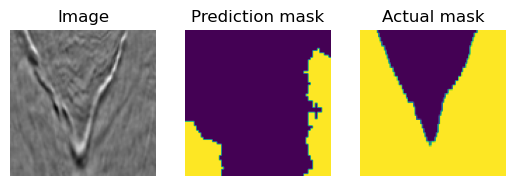

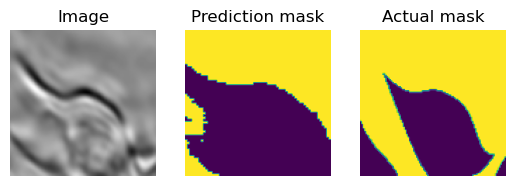

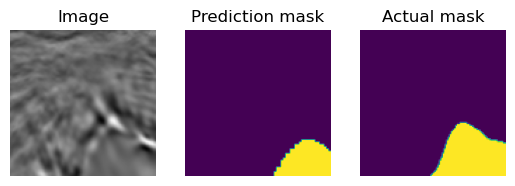

In [22]:
L.seed_everything(45)
plot_prediction_and_actual(data_set=validation_data,
                           model=versiond_9,
                           output_img_size=104)

Seed set to 45


<Figure size 500x400 with 0 Axes>

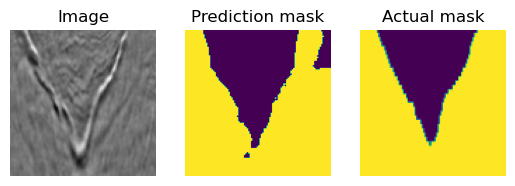

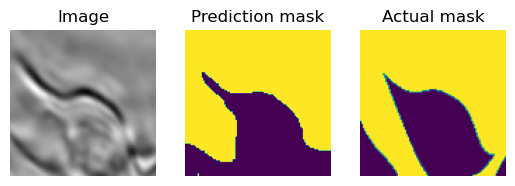

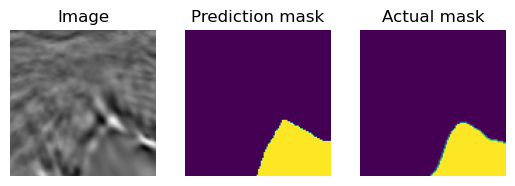

In [146]:
L.seed_everything(45)
plot_prediction_and_actual(data_set=validation_data,
                           model=version_23,
                           output_img_size=104)

I compared the difference in inference time of the two model as verison_9 contain less parameters than version_13

In [124]:
random_tensor = torch.rand((1, 3, 104, 104))

In [81]:
%%timeit
version_9.eval()
with torch.inference_mode():
    version_9(random_tensor.to(device))

1.19 ms ± 51.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [125]:
%%timeit
version_23.eval()
with torch.inference_mode():
    version_23(random_tensor.to(device))

1.79 ms ± 167 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
